In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import math
import seaborn as sns
import warnings
from time import time
from scipy import stats
import tensorflow as tf

In [89]:
warnings.filterwarnings('ignore')

In [90]:
url = r'C:\Users\along\Downloads\individual+household+electric+power+consumption\household_power_consumption.txt'

In [91]:
power_df = pd.read_csv(url, sep=';', header=0, parse_dates={'DateTime' : ['Date','Time']}, infer_datetime_format=True, na_values=['nan','?'], index_col='DateTime')

In [92]:
power_df.shape

(2075259, 7)

In [93]:
power_df.head()

Global_active_power  Global_reactive_power  Voltage  \
DateTime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
DateTime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

In [94]:
power_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [95]:
power_df.describe()

Global_active_power  Global_reactive_power       Voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237145e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627759e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00  
50%        2.600000e+00    0.000000e+00    0.000000e+00    1.000000e+00  
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01  
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01

In [96]:
power_df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

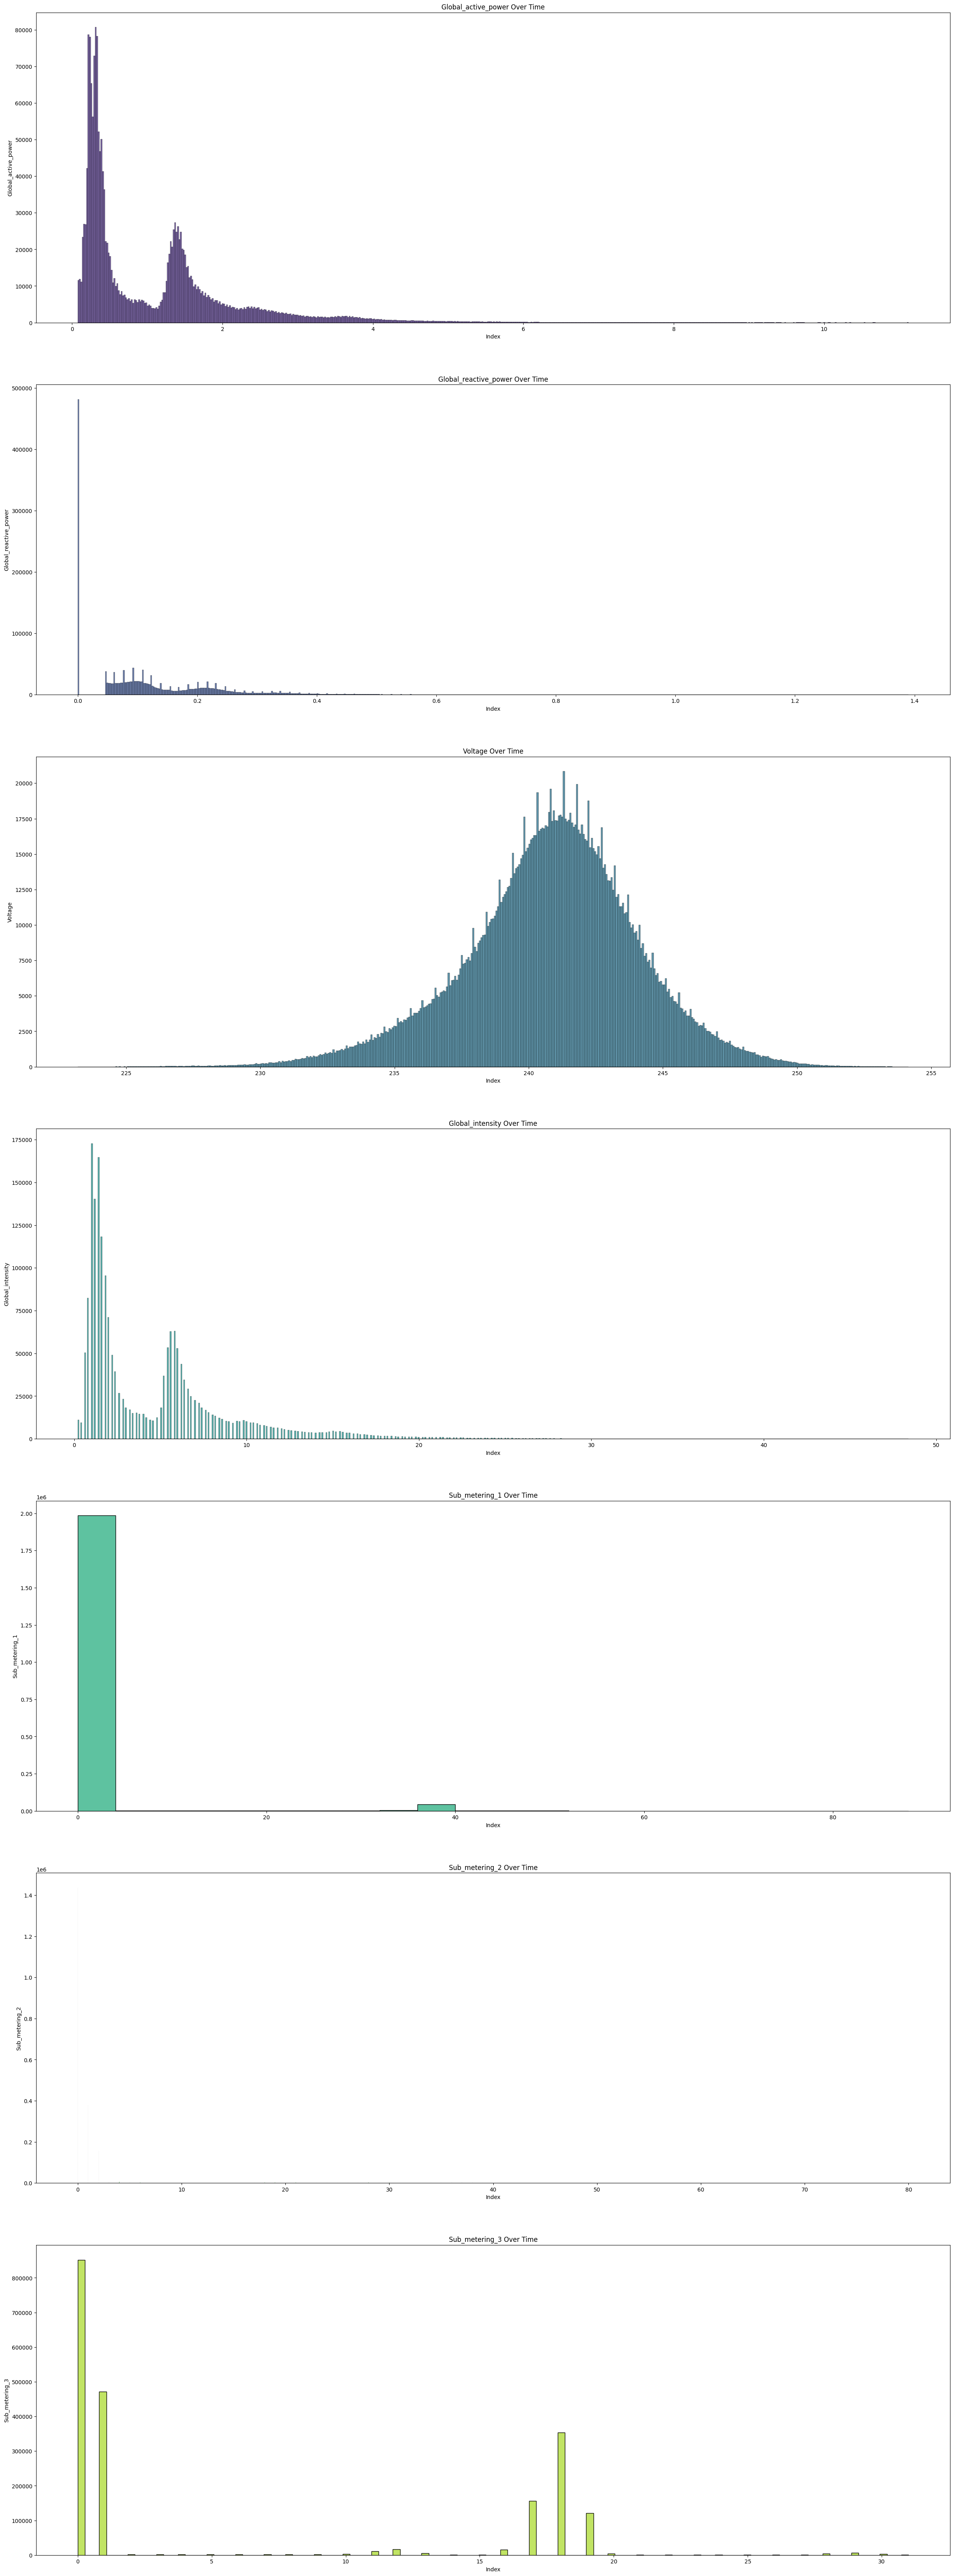

In [97]:
num_cols = len(power_df.columns)
palette = sns.color_palette('viridis', num_cols)

fig, axes = plt.subplots(num_cols, 1, figsize=(30, 12 * num_cols))

for i, (col, color) in enumerate(zip(power_df.columns, palette)):
    sns.histplot(data=power_df[col], ax=axes[i], color=color)
    axes[i].set_title(f'{col} Over Time')
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(col)

plt.show()

As we can see, for every feature in the dataset there are 25979 missing values.
As a part of the preprocessing for the training process I'll complete the missing values. 
But I want to see before the explore the data with the missing values to be able to check the data for seasonality and cyclic intervals.

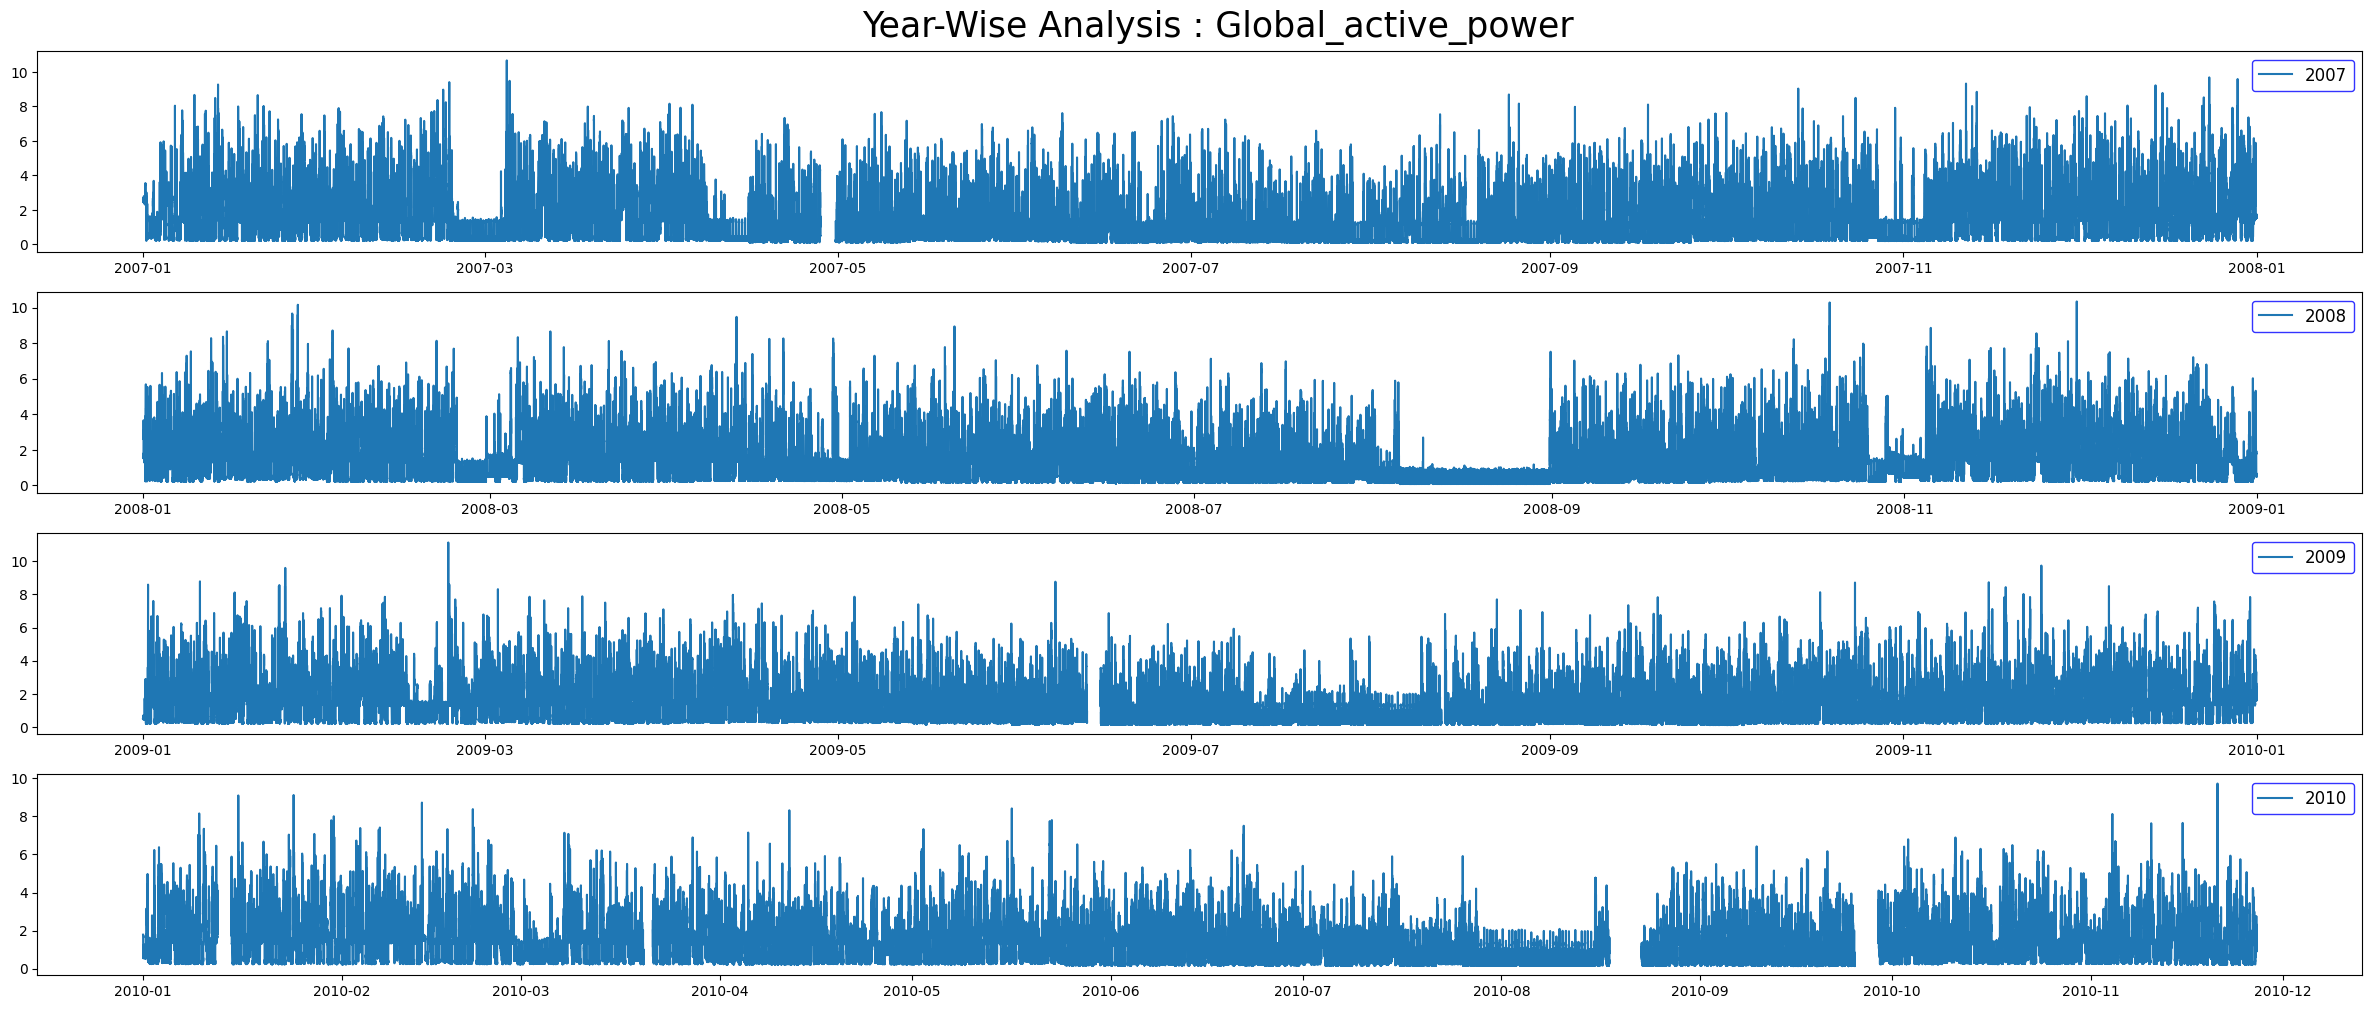

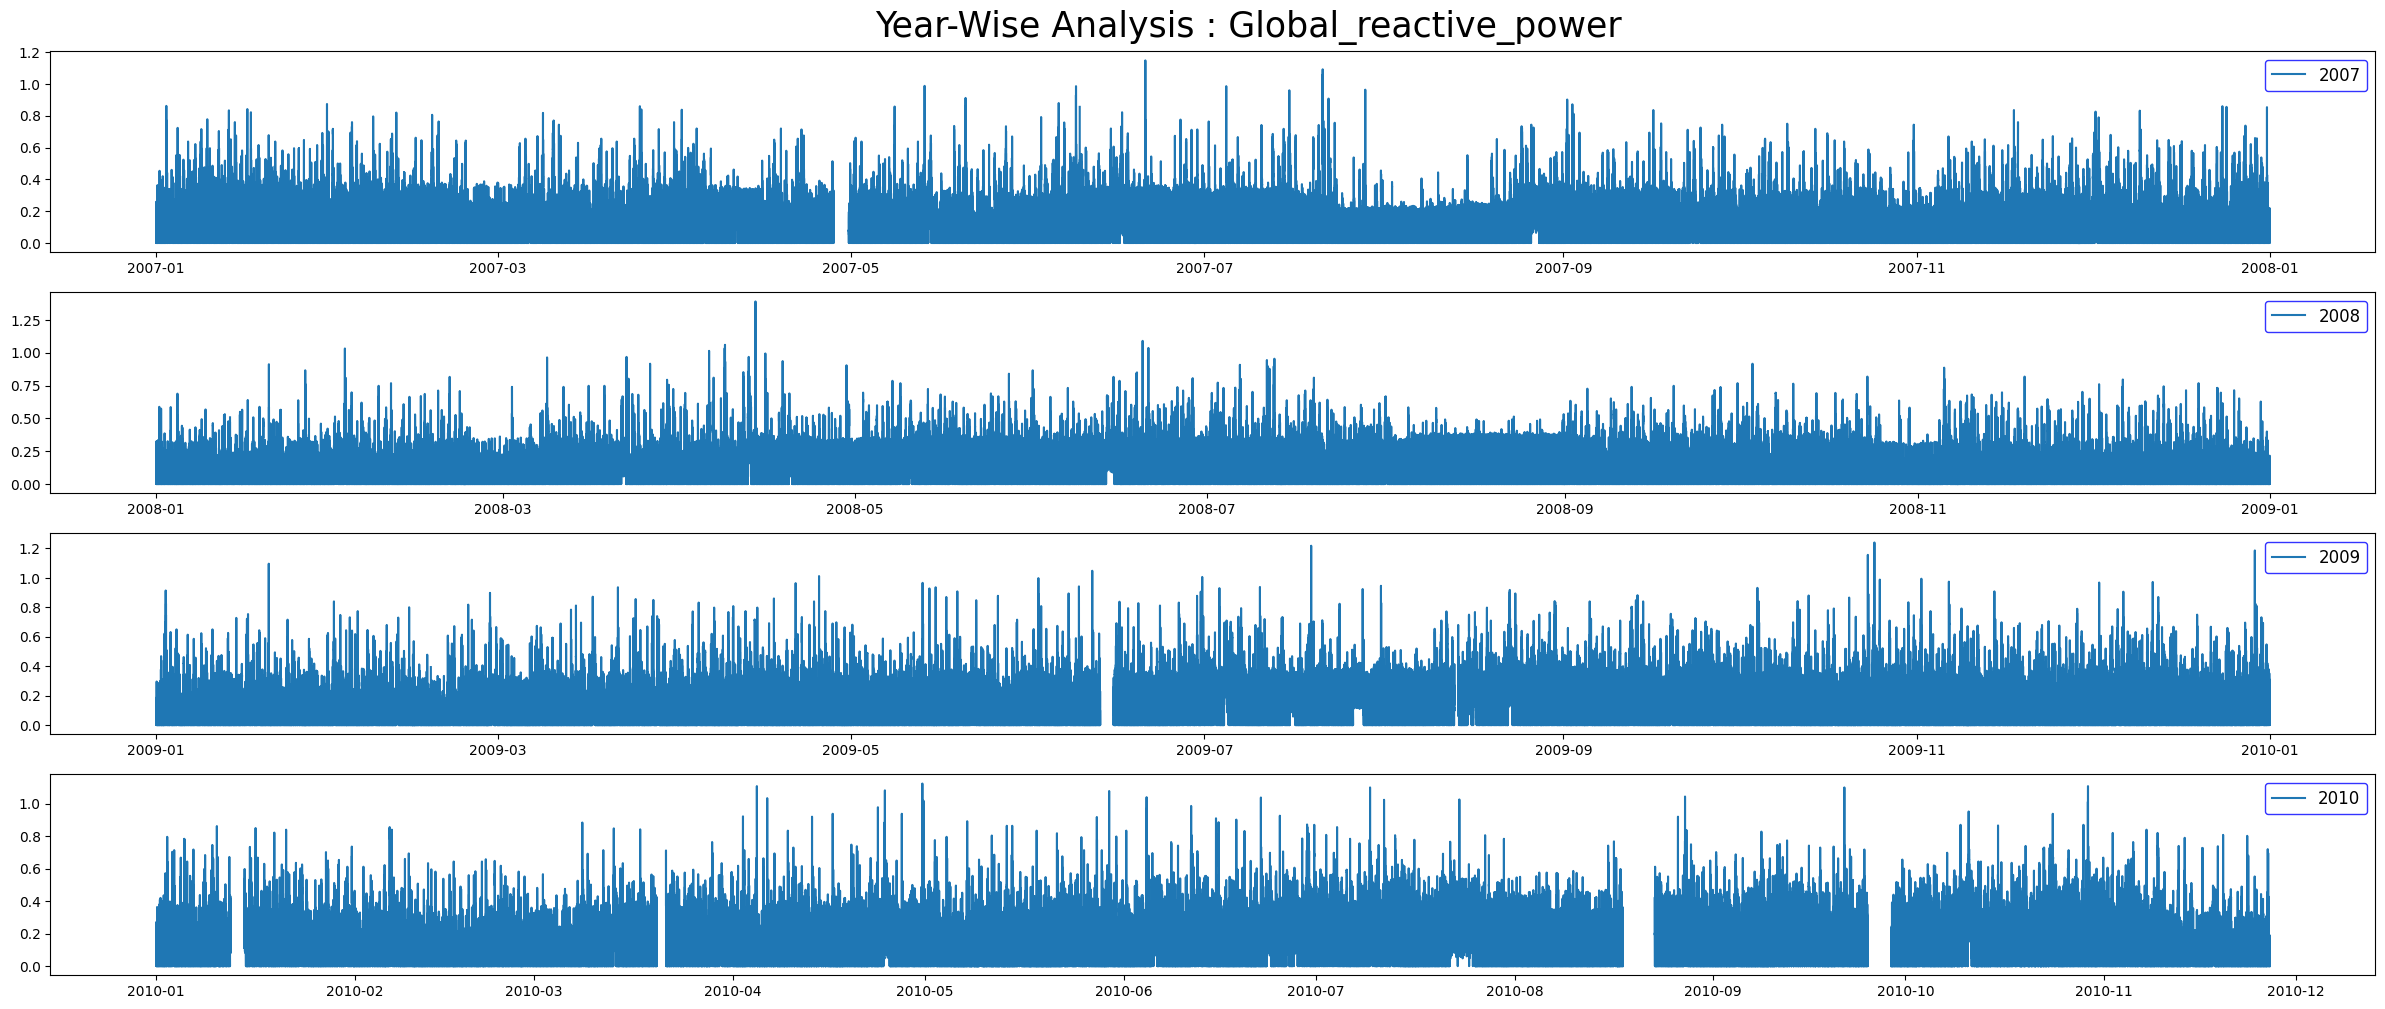

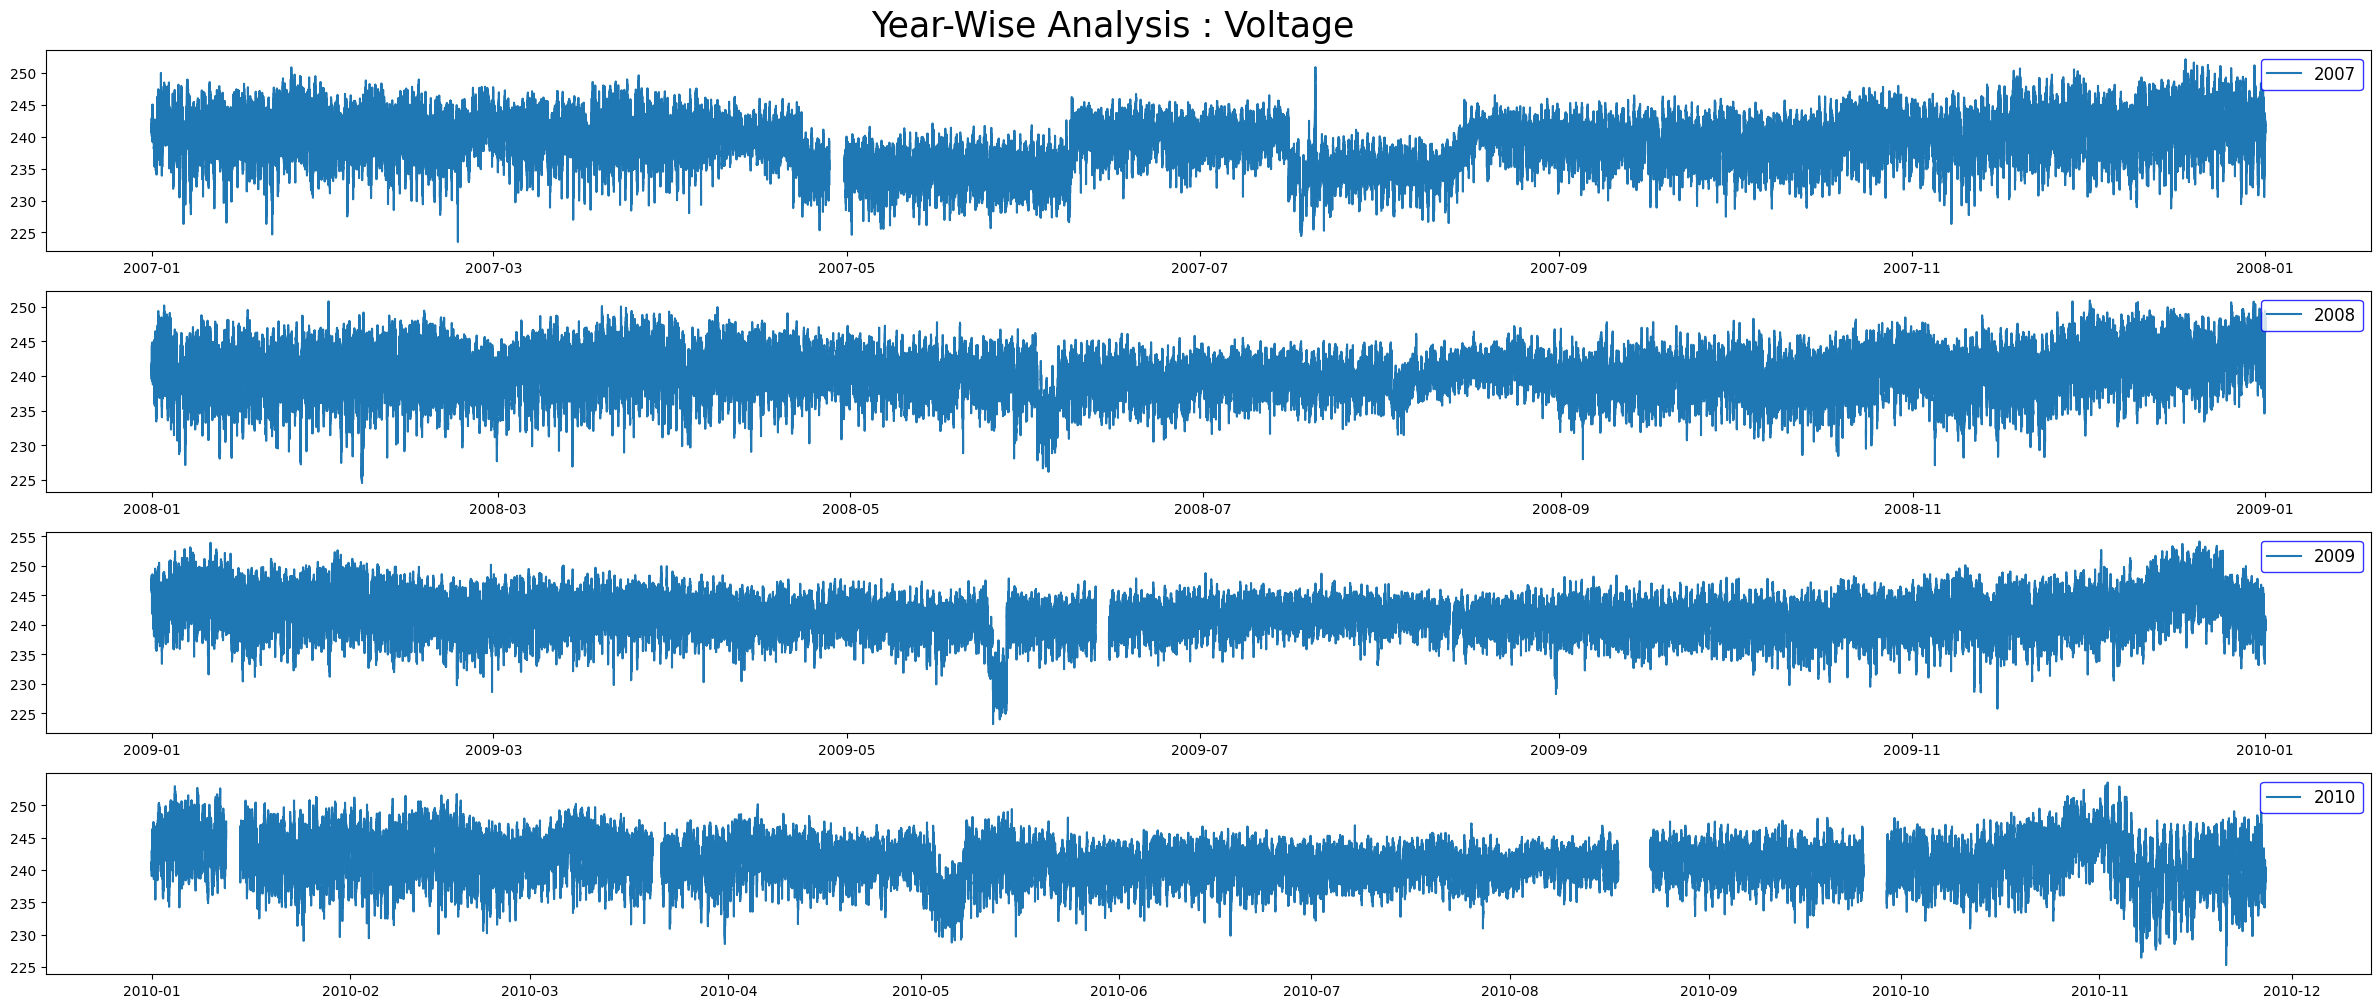

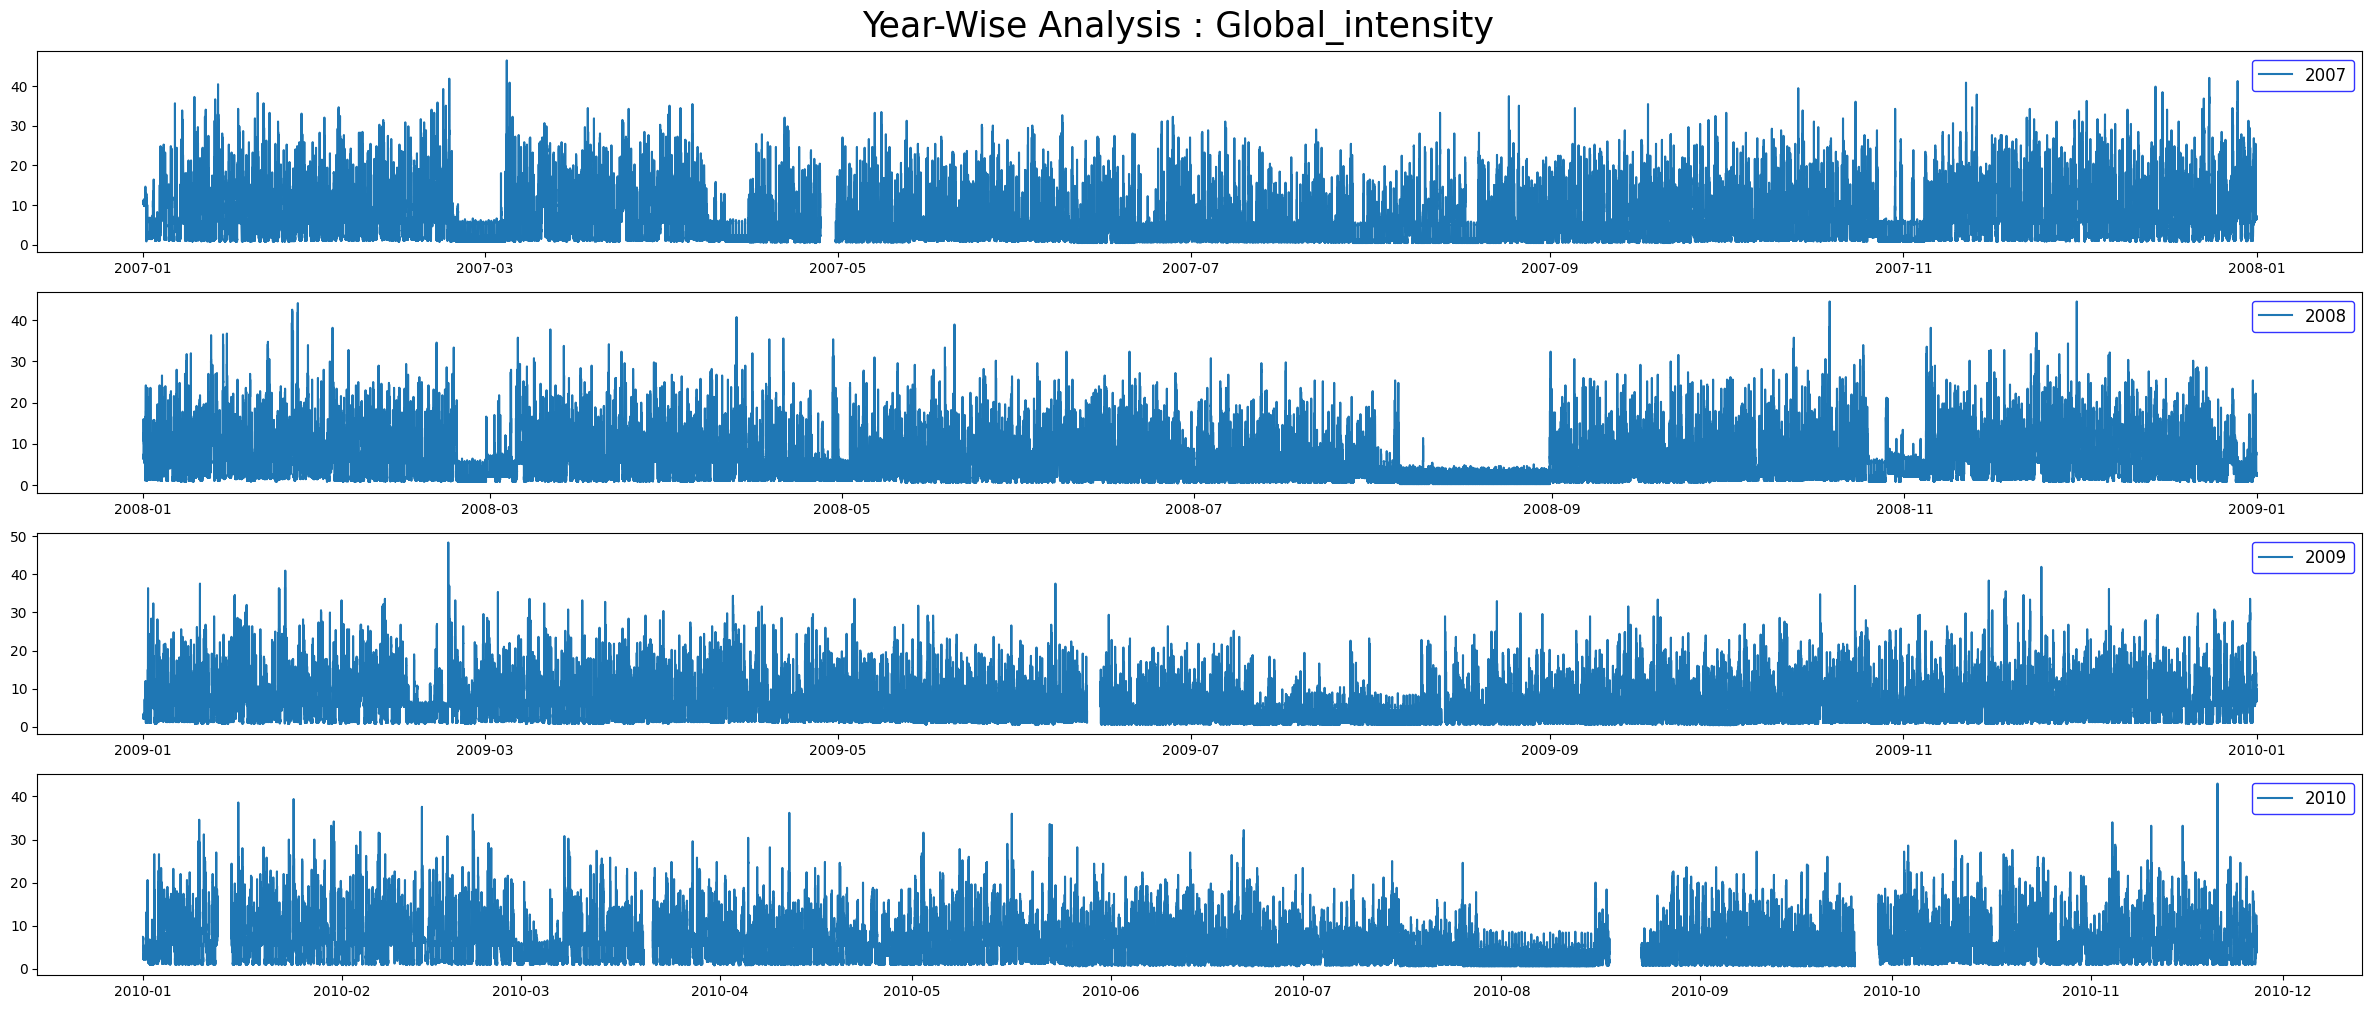

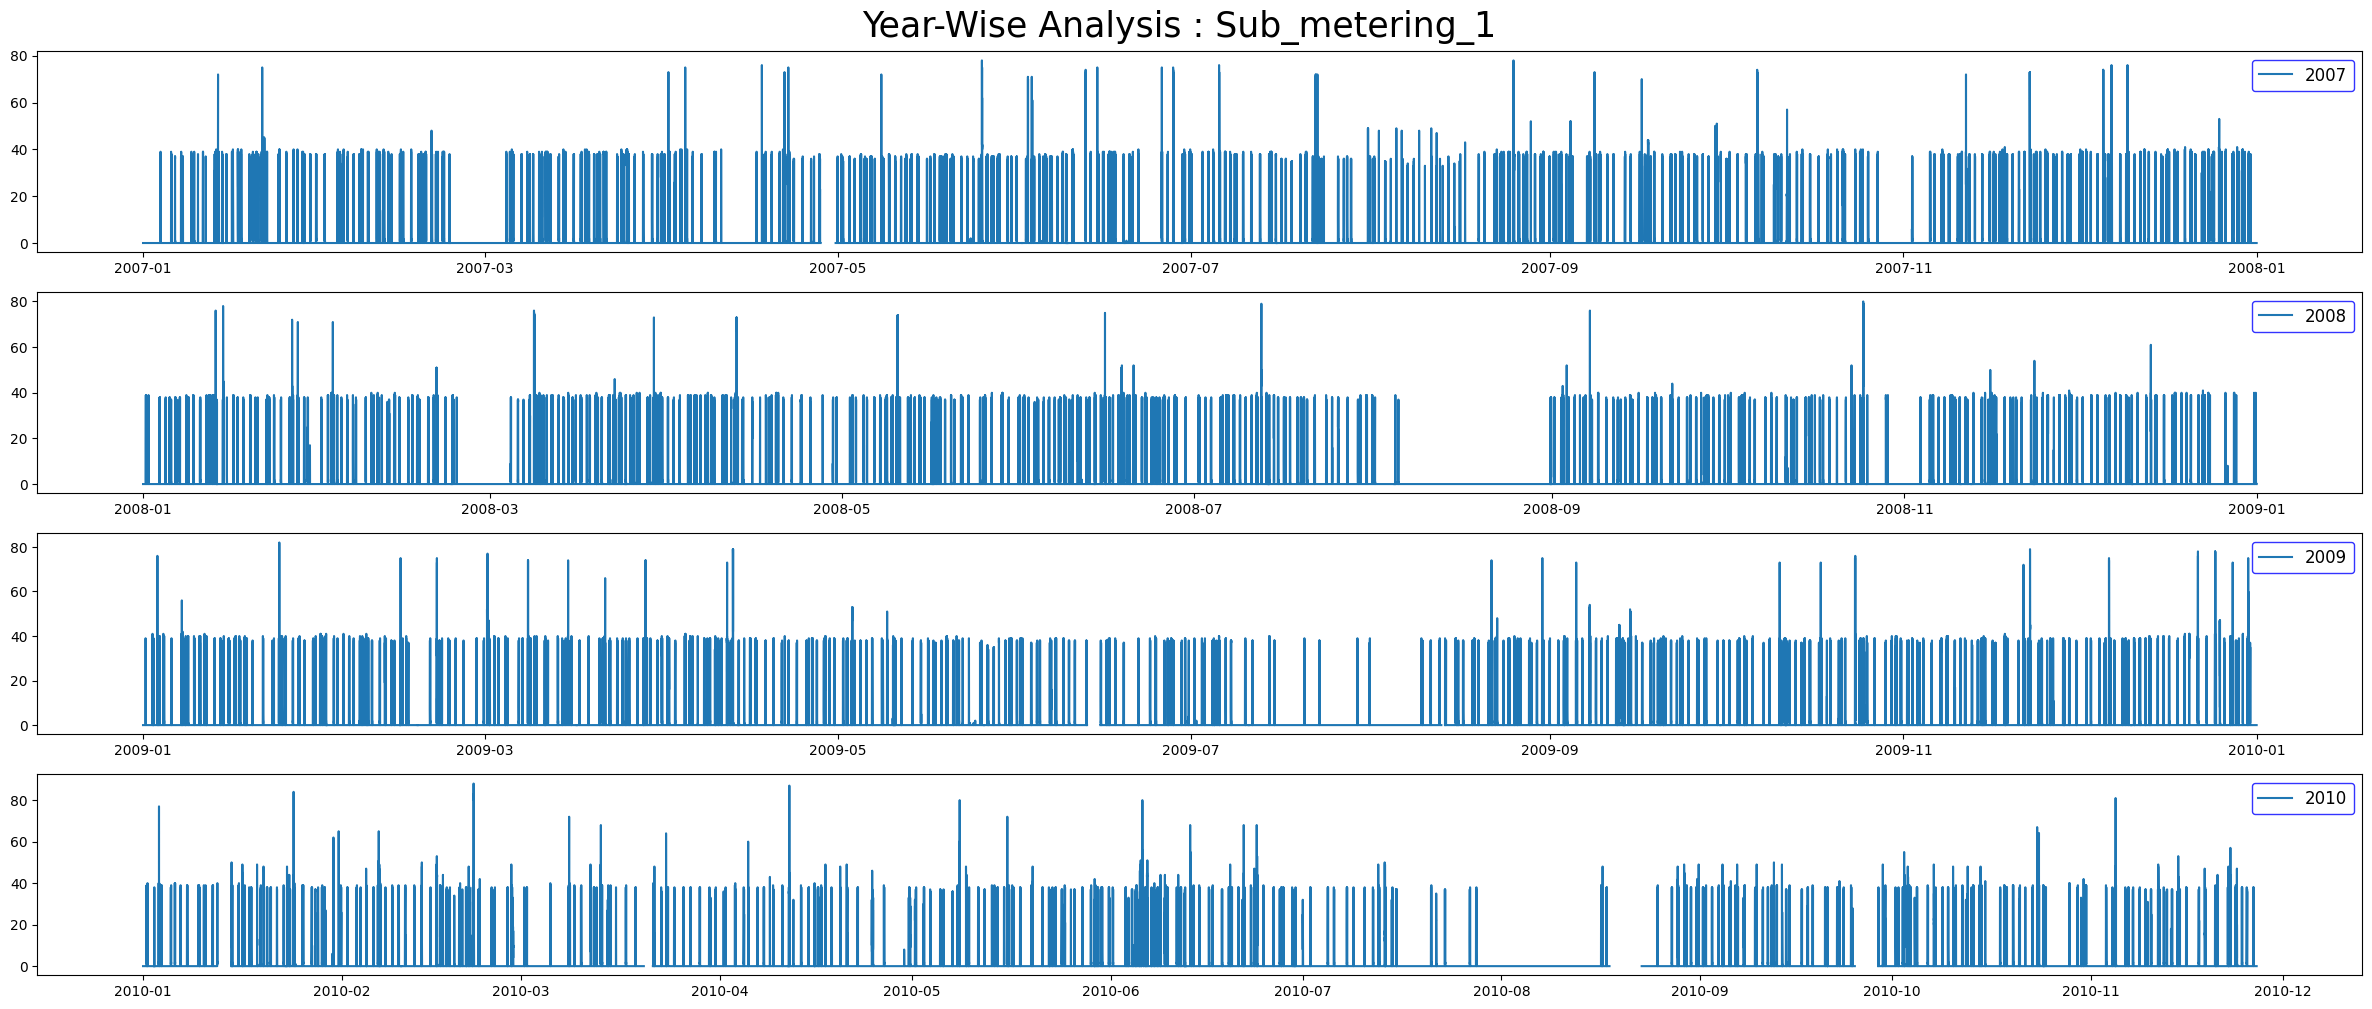

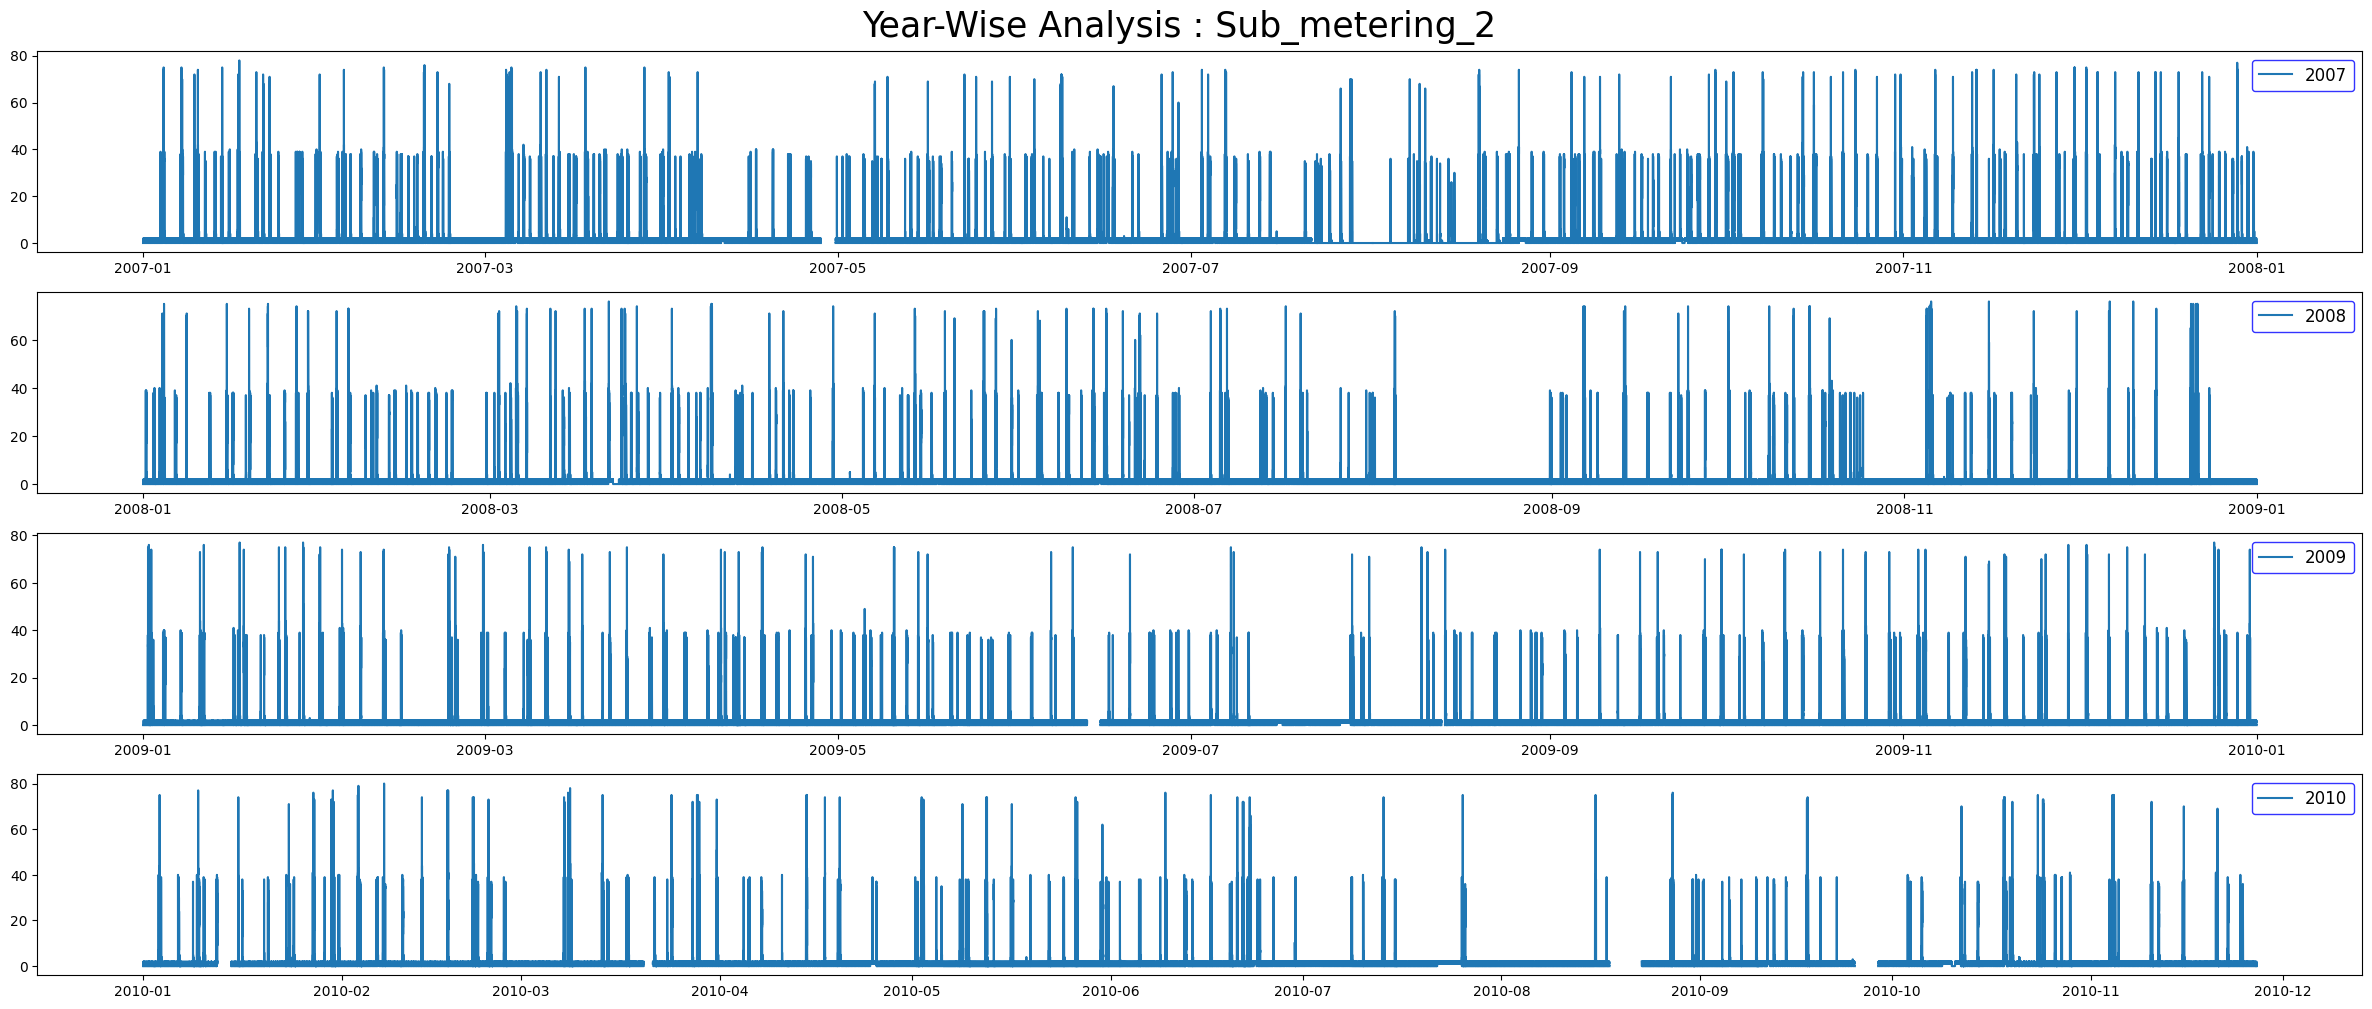

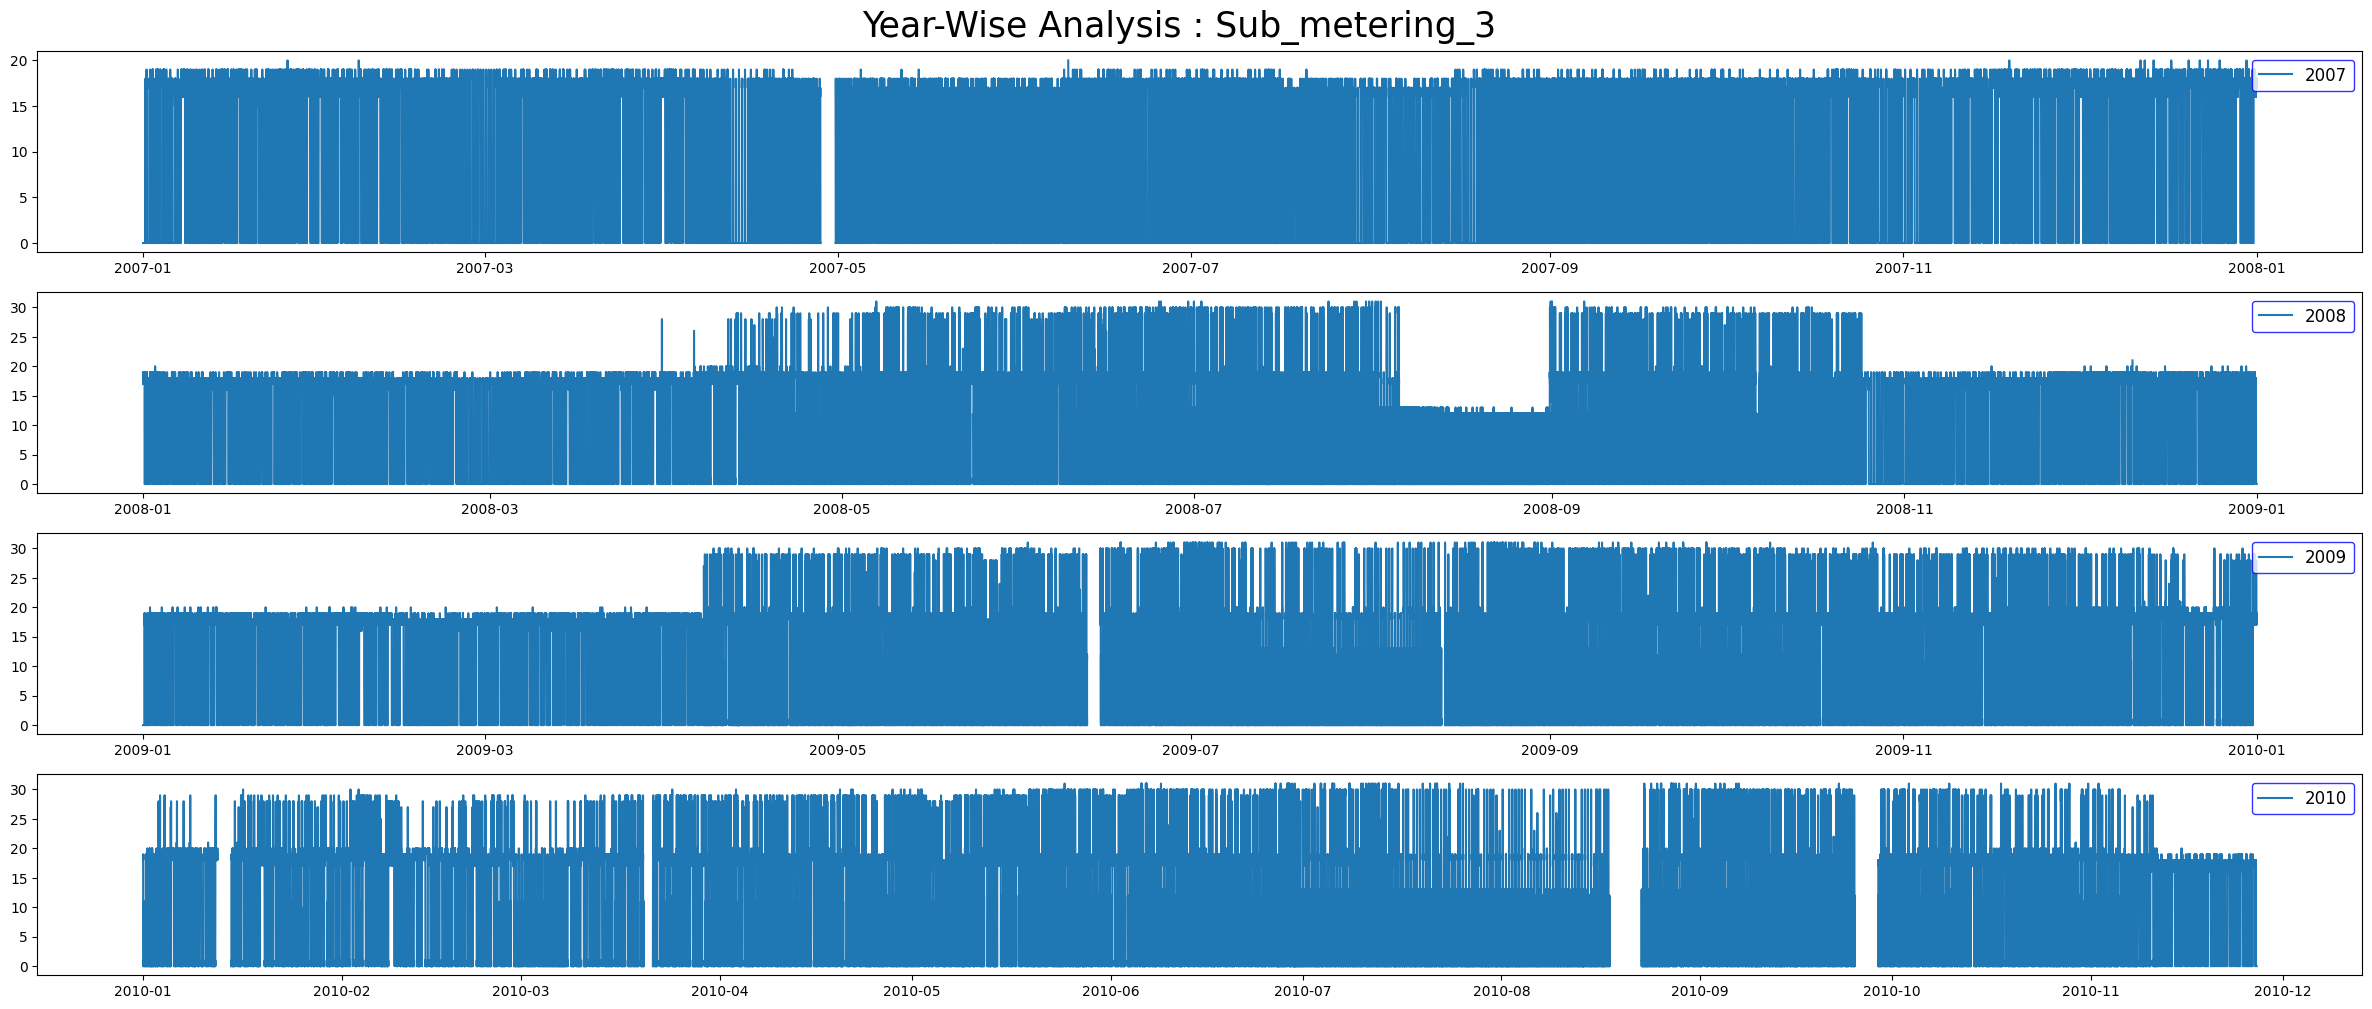

In [98]:
for feat_name in power_df.columns:    
    fig, axis = plt.subplots(4, 1, figsize=(30, 12))

    for i, d in enumerate(zip(axis, list(power_df[feat_name].groupby(power_df.index.year))[1:])):
        d[0].plot(pd.DataFrame(d[1][1]), label=d[1][0])
        d[0].legend(loc='upper right', fontsize='12', frameon=True).get_frame().set_edgecolor('blue') 
    
    fig.text(0.40, 0.9, 'Year-Wise Analysis : %s ' %feat_name, va='center',  fontdict={'fontsize': 25})
    plt.show()    

As mentioned before, it's noticable that there are missing values in the dataset (In 2007, 2009 and 2010).
There are some key insights regarding the seasonality and cyclic intervals in the data:
* Global Active Power - 
    * There is a yearly seasonal pattern with some spikes.
    * Every year there is a decrease on July and August and an increase from September to December.
* Global Reactive Power -
    * There is a yearly seasonal pattern with some spikes. Even tho it shows less variation compared to Global Active Power.
* Voltage - 
    * There is a repeating seasonal pattern - In the beginning of the year the voltage fluctuates between 250 and 260. Around summer time (near July) there is a reduction and then it spikes back towards the end of the year.
* Global Intensity - 
    * The values spike towards the beginning of the year and then become almost constant repeatedly each year.
    * Every year there is a decrease around August.
* Sub Metering 1 (Kitchen Area) -
    * The values of this feature are constant throughout the year with some spikes occationally.
* Sub Metering 2 (Launday area) - 
    * The values of this feature are in periodic intervals throughout the year with some spikes.
* Sub Metering 3 (Water Heater and AC) -
    * In 2007 the values are constant with occasional spikes
    * In 2008 there is a significant increase the usage 
    * Between May 2009 and November 2010 there is a significant increase in the usage after a decrease after 2008

After analyzing the data with missing values, I'll replace the missing values of each feature with its' mean value for the relative year.

In [99]:
data = []
for d in list(power_df.groupby(power_df.index.year)):
    data.append(d[1].fillna(d[1].mean()))

power_df = pd.DataFrame(np.vstack(data), index=power_df.index, columns=power_df.columns)    

In [100]:
power_df.head()

Global_active_power  Global_reactive_power  Voltage  \
DateTime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
DateTime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

In [101]:
power_df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

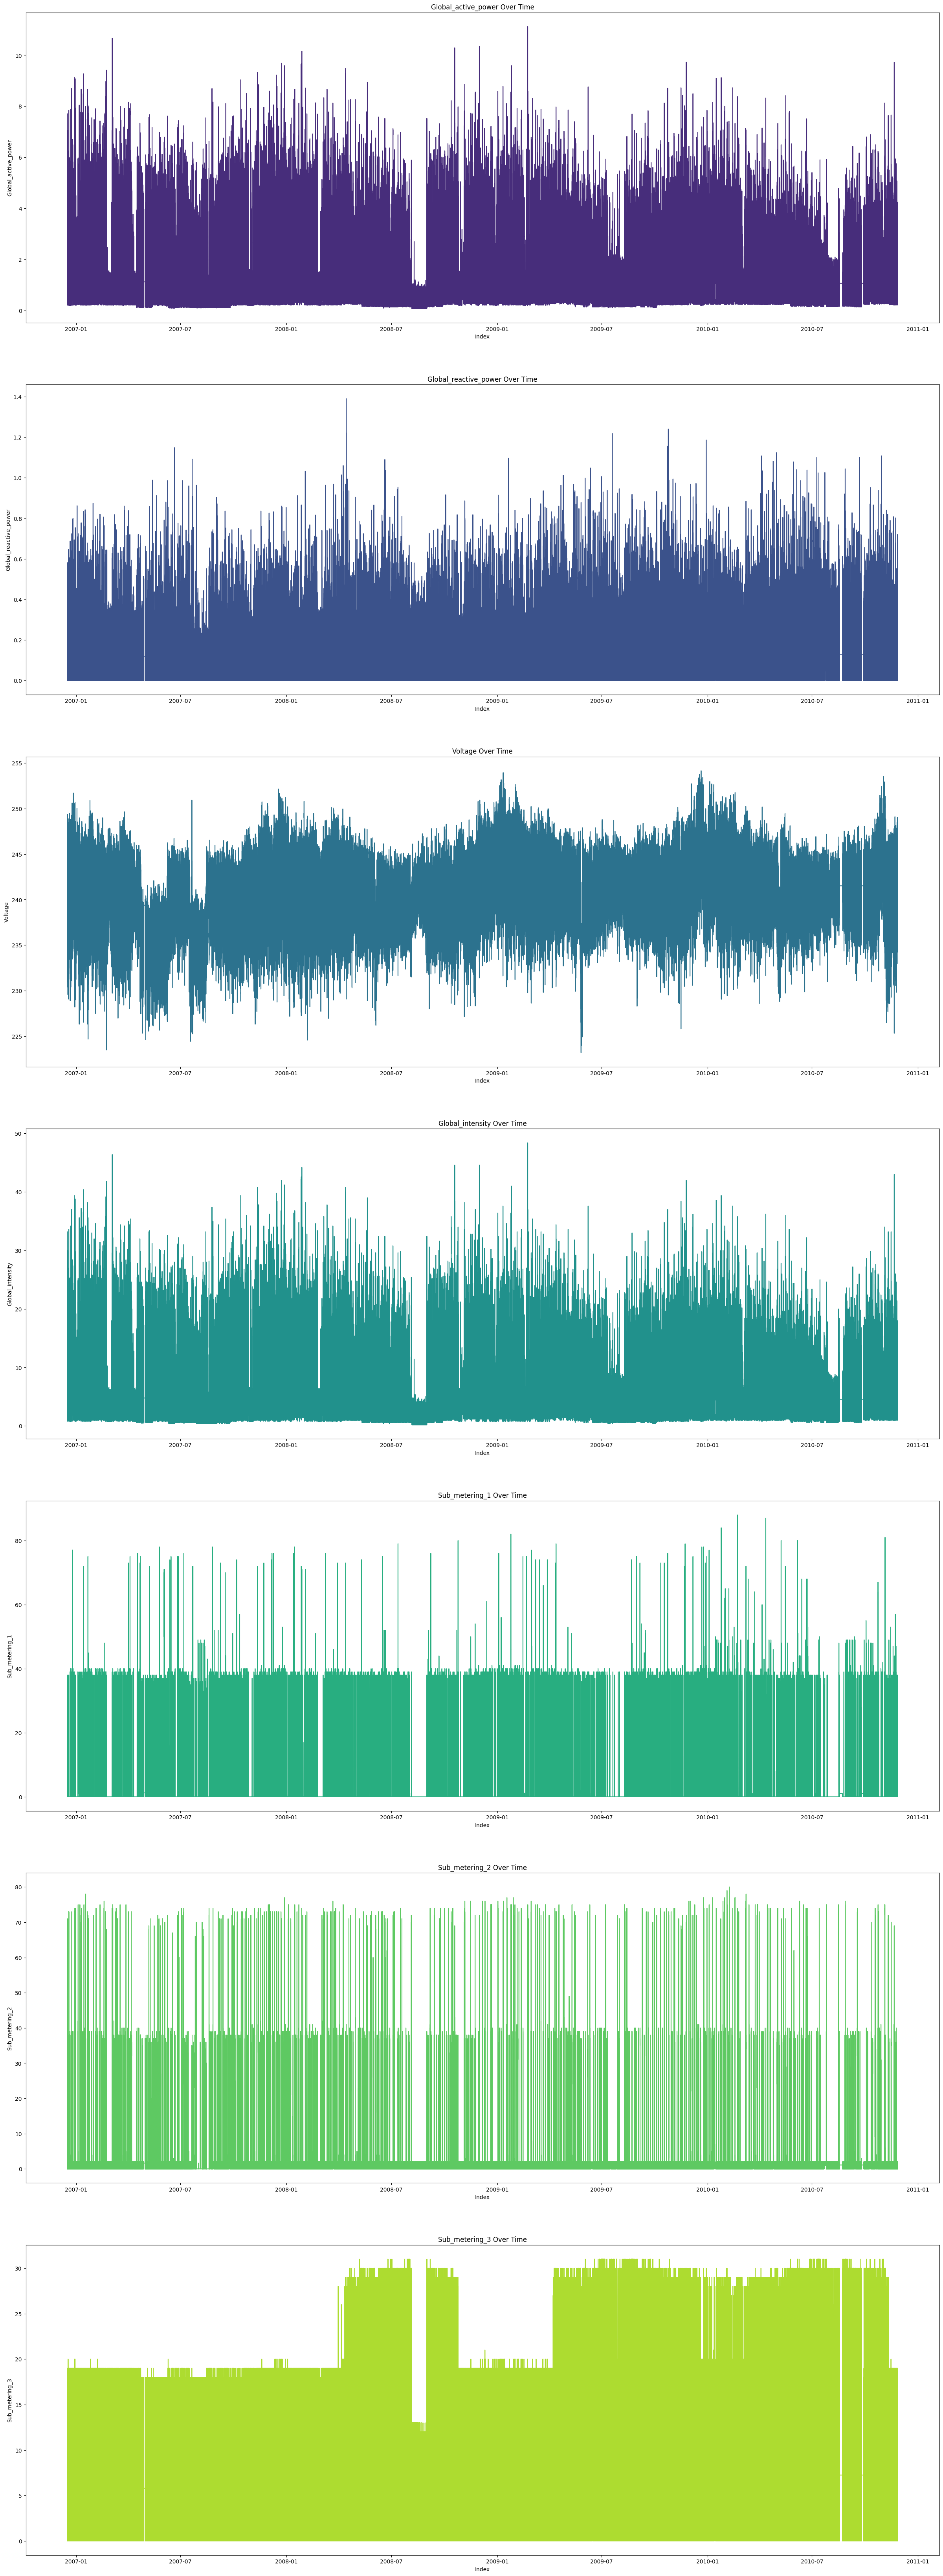

In [102]:
num_cols = len(power_df.columns)
palette = sns.color_palette('viridis', num_cols)

fig, axes = plt.subplots(num_cols, 1, figsize=(30, 12 * num_cols))

for i, (col, color) in enumerate(zip(power_df.columns, palette)):
    sns.lineplot(data=power_df[col], ax=axes[i], color=color)
    axes[i].set_title(f'{col} Over Time')
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(col)

plt.show()

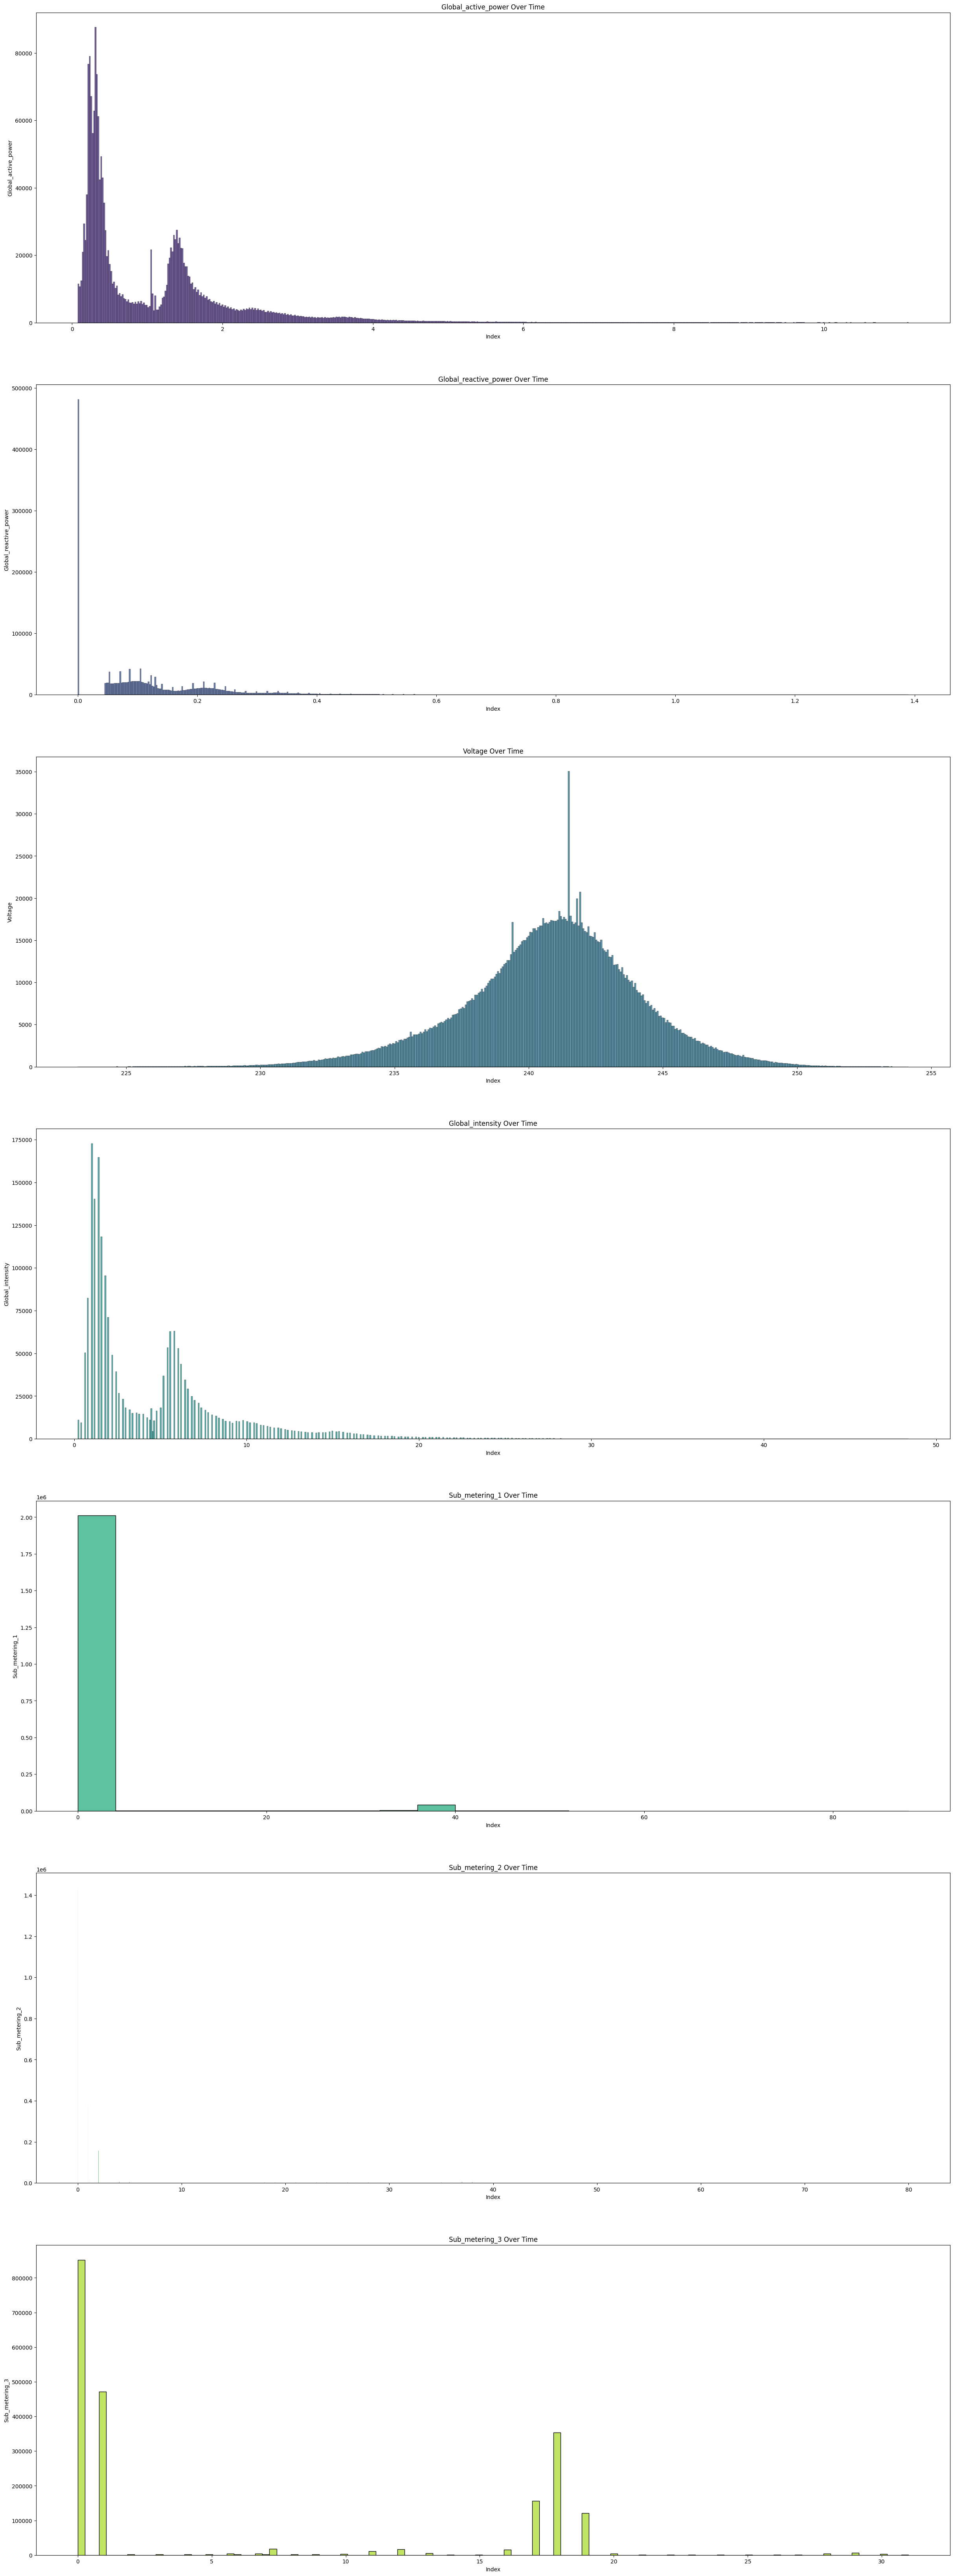

In [103]:
num_cols = len(power_df.columns)
palette = sns.color_palette('viridis', num_cols)

fig, axes = plt.subplots(num_cols, 1, figsize=(30, 12 * num_cols))

for i, (col, color) in enumerate(zip(power_df.columns, palette)):
    sns.histplot(data=power_df[col], ax=axes[i], color=color)
    axes[i].set_title(f'{col} Over Time')
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(col)

plt.show()

* As it shows, the Voltage feature's distribution is close to a normal distribution.
* The other features tend to have lower values.

<Axes: >

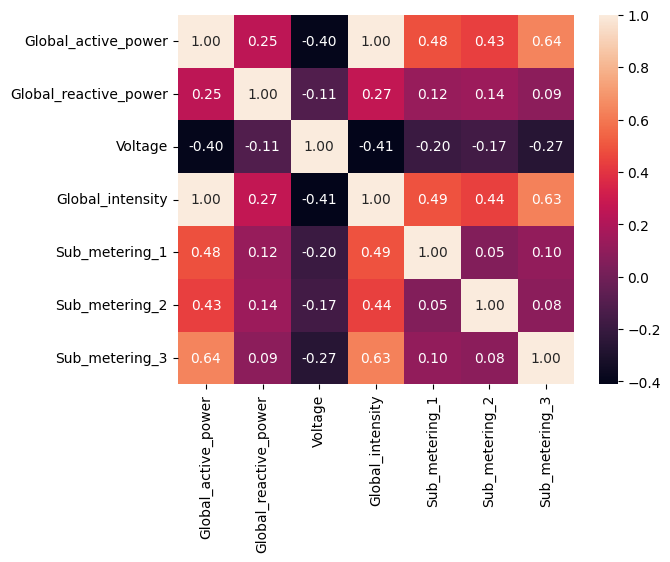

In [104]:
sns.heatmap(power_df.corr(), annot=True, fmt='.2f')

In [105]:
power_df['power_consumption'] = (power_df['Global_active_power']*1000/60) - (power_df['Sub_metering_1'] + power_df['Sub_metering_2'] + power_df['Sub_metering_3'])

<Axes: xlabel='power_consumption', ylabel='Count'>

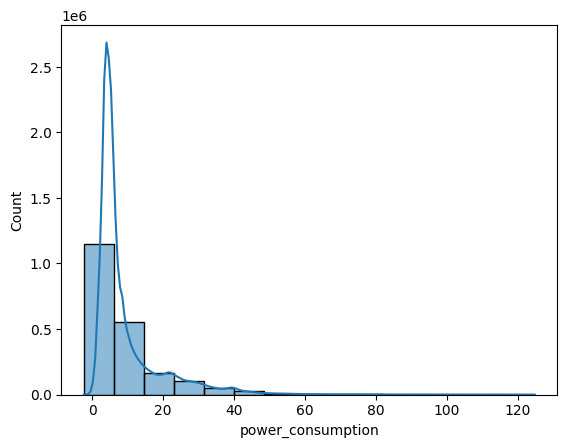

In [106]:
sns.histplot(power_df['power_consumption'], kde=True, bins=15)

<Axes: >

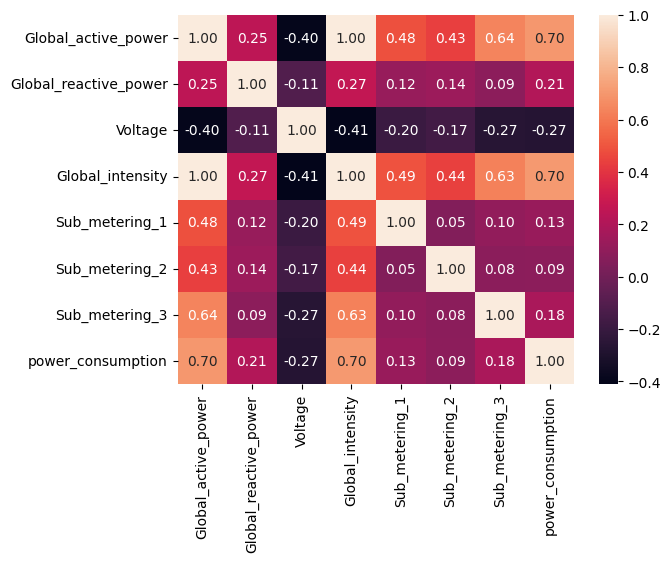

In [107]:
sns.heatmap(power_df.corr(), annot=True, fmt='.2f')

Plot Functions:

In [108]:
def plot_loss_over_training(history):
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend(loc='upper right')
  plt.show()

def plot_preds_and_true(y_pred, y_true):
  plt.figure(figsize=(15, 5))
  plt.plot(y_pred, label='Predictions')
  plt.plot(y_true, label='True Values')
  plt.title('True Values vs Predictions')
  plt.xlabel('Time')
  plt.ylabel('Power Consumption')
  plt.legend()
  plt.show()

Data preparation:

In [109]:
SPLIT =  3 * 24 * 60
def data_split(data):
    split = SPLIT
    train = data[:-split]
    test = data[-split:]
    print('data_split finish')
    return train, test

In [110]:
SEQ_LENGTH = 24
def create_seq(data):
    sequences = []
    targets = []
    for i in range(len(data) - SEQ_LENGTH):
        seq = data[i:i + SEQ_LENGTH]
        target = data[i + SEQ_LENGTH]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [111]:
def create_features(df):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year

    for lag in range(1, 4):
        df[f'lag_{lag}'] = df['power_consumption'].shift(lag)

    df.dropna(inplace=True)
    return df

Linear Regression:

data_split finish
Mean Absolute Error (LR): 1.085295586244106
Mean Squared Error (LR): 6.017546993629511
Root Mean Squared Error (LR): 2.4530688929643847
R-squared (LR): 0.9290612343514054
Last three predictions: [15.54912081 15.45832303 15.40420212]
Last three true values: [15.63333333 15.56666667 15.53333333]


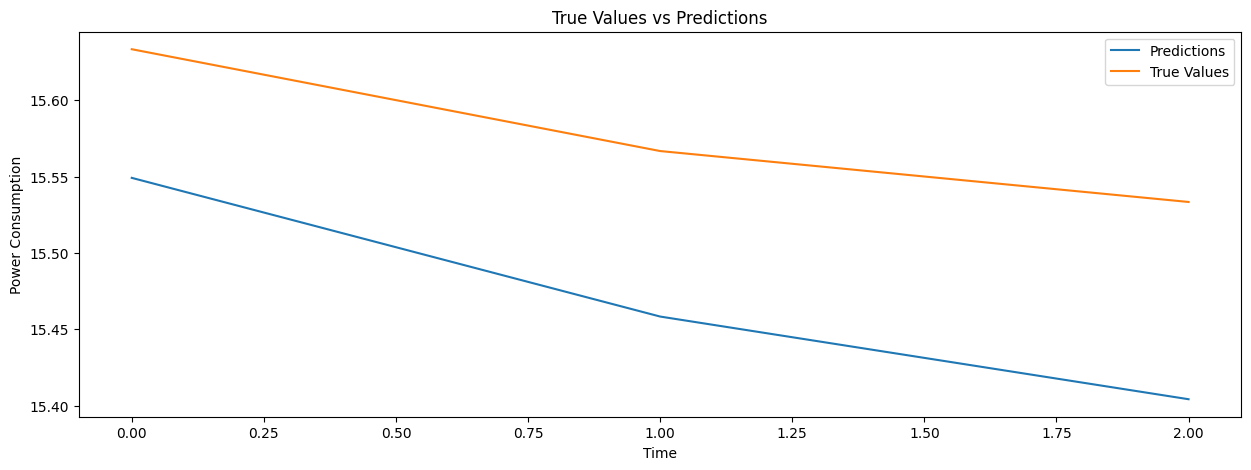

In [112]:
features = [f'lag_{lag}' for lag in range(1, 4)]
features.append('year')
features.append('month')
features.append('hour')
features.append('day_of_week')
features.append('day')

train, test = data_split(power_df)

train_lr = create_features(train.copy())
test_lr = create_features(test.copy())

x_train = train_lr[features]
y_train = train_lr['power_consumption']
x_test = test_lr[features]
y_test = test_lr['power_consumption']

lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

y_test_lr = y_test.values

mse = mean_squared_error(y_test_lr, y_pred)
mae = mean_absolute_error(y_test_lr, y_pred)
r2 = r2_score(y_test_lr, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (LR): {mae}')
print(f'Mean Squared Error (LR): {mse}')
print(f'Root Mean Squared Error (LR): {rmse}')
print(f'R-squared (LR): {r2}')

pred_last_3 = y_pred[-3:]
test_last_3 = y_test_lr[-3:]

print(f'Last three predictions: {pred_last_3.flatten()}')
print(f'Last three true values: {test_last_3}')

plot_preds_and_true(y_pred=pred_last_3, y_true=test_last_3)

Simple RNN:

In [113]:
scaler = MinMaxScaler()

scaled_df = create_features(power_df.copy())

scaled_df['power_consumption'] = scaler.fit_transform(scaled_df[['power_consumption']])

X, y = create_seq(scaled_df['power_consumption'].values)

X_train, X_test = data_split(X)
y_train, y_test = data_split(y)

# X_train, y_train = create_seq(train['power_consumption'].values)
# X_test, y_test = create_seq(test['power_consumption'].values)

# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features)))

data_split finish
data_split finish


In [114]:
def create_rnn(X_train, y_train, X_test, y_test):
    rnn = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
        tf.keras.layers.Dense(1)
    ])

    print('Start training')
    rnn.compile(optimizer='adam', loss='mean_squared_error')
    history = rnn.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))
    print('End training')

    test_loss = rnn.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss:.4f}")

    y_pred = rnn.predict(X_test)

    y_pred = scaler.inverse_transform(y_pred)
    y_test_rnn = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_rnn, y_pred)
    mae = mean_absolute_error(y_test_rnn, y_pred)
    r2 = r2_score(y_test_rnn, y_pred)
    rmse = np.sqrt(mse)

    print(f'Mean Absolute Error (RNN): {mae}')
    print(f'Mean Squared Error (RNN): {mse}')
    print(f'Root Mean Squared Error (RNN): {rmse}')
    print(f'R-squared (RNN): {r2}')

    plot_loss_over_training(history)
    plot_preds_and_true(y_pred, y_test_rnn)

Start training
Epoch 1/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 5.1779e-04 - val_loss: 3.8499e-04
Epoch 2/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 4.6715e-04 - val_loss: 3.6378e-04
Epoch 3/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 4.6220e-04 - val_loss: 3.9285e-04
Epoch 4/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 4.5602e-04 - val_loss: 3.8288e-04
Epoch 5/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 4.5503e-04 - val_loss: 3.6357e-04
Epoch 6/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 4.5305e-04 - val_loss: 3.6626e-04
Epoch 7/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 4.5528e-04 - val_loss: 3.7408e-04
Epoch 8/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 4.5489e-04 - val_loss: 3.6206e-04
Epoch 9/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 4.4287e-04 - val_loss: 3.7864e-04
Epoch 10/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 4.4386e-04 - val_loss: 3.677

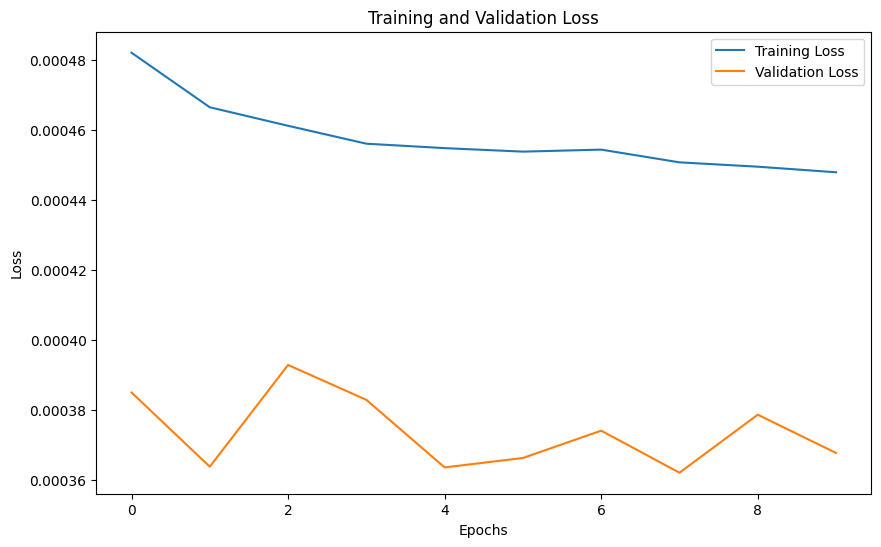

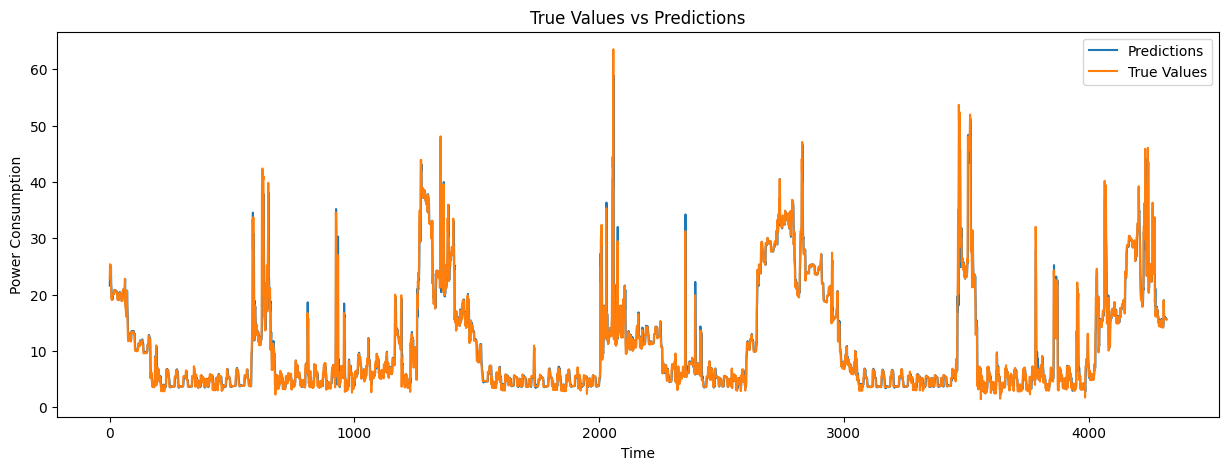

In [115]:
create_rnn(X_train, y_train, X_test, y_test)

Comparison between Linear Regression Model and RNN:
* MAE - RNN has a lower MAE score compared to the Linear Regression, indicating that on average the predictions of RNN are closer to their real values than the predictions of Linear Regression.
* MSE & RMSE - RNN has lower MSE and RMSE scores compared to the Linear Regression, indicating that besides the fact that on average the predictions of RNN are closer to their real values, it also indicates that RNN has fewer large errors.
* R-squared - RNN has a higher R-squared score compared to the Linear Regression, indicating that the RNN explains a bit more of the variance in the dataset than the Linear Regression model.
* The RNN outperforms the Linear Regression across all performance metrics, which indicates that the provided RNN model is better suited for this task than the provided Linear Regression model.

LSTM:

In [116]:
def create_LSTM(X_train, y_train, X_test, y_test):
    lstm = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
        tf.keras.layers.Dense(1)
    ])

    print('Start training')
    lstm.compile(optimizer='adam', loss='mean_squared_error')
    history = lstm.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))
    print('End training')

    test_loss = lstm.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss:.4f}")

    y_pred = lstm.predict(X_test)

    y_pred = scaler.inverse_transform(y_pred)
    y_test_lstm = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_lstm, y_pred)
    mae = mean_absolute_error(y_test_lstm, y_pred)
    r2 = r2_score(y_test_lstm, y_pred)
    rmse = np.sqrt(mse)

    print(f'Mean Absolute Error (LSTM): {mae}')
    print(f'Mean Squared Error (LSTM): {mse}')
    print(f'Root Mean Squared Error (LSTM): {rmse}')
    print(f'R-squared (LSTM): {r2}')

    plot_loss_over_training(history)
    plot_preds_and_true(y_pred, y_test_lstm)

Start training
Epoch 1/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 133s 8ms/step - loss: 6.0058e-04 - val_loss: 3.5895e-04
Epoch 2/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 129s 8ms/step - loss: 4.6785e-04 - val_loss: 3.6273e-04
Epoch 3/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 129s 8ms/step - loss: 4.5862e-04 - val_loss: 3.5991e-04
Epoch 4/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 129s 8ms/step - loss: 4.4818e-04 - val_loss: 3.6856e-04
Epoch 5/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 129s 8ms/step - loss: 4.3947e-04 - val_loss: 3.7172e-04
Epoch 6/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 129s 8ms/step - loss: 4.3932e-04 - val_loss: 3.5518e-04
Epoch 7/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 129s 8ms/step - loss: 4.3610e-04 - val_loss: 3.6458e-04
Epoch 8/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 130s 8ms/step - loss: 4.3503e-04 - val_loss: 3.5786e-04
Epoch 9/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 130s 8ms/step - loss: 4.3472e-04 - val_loss: 3.6218e-04
Epoch 10/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 131s 8ms/step - loss: 4.3345e-04 - val_l

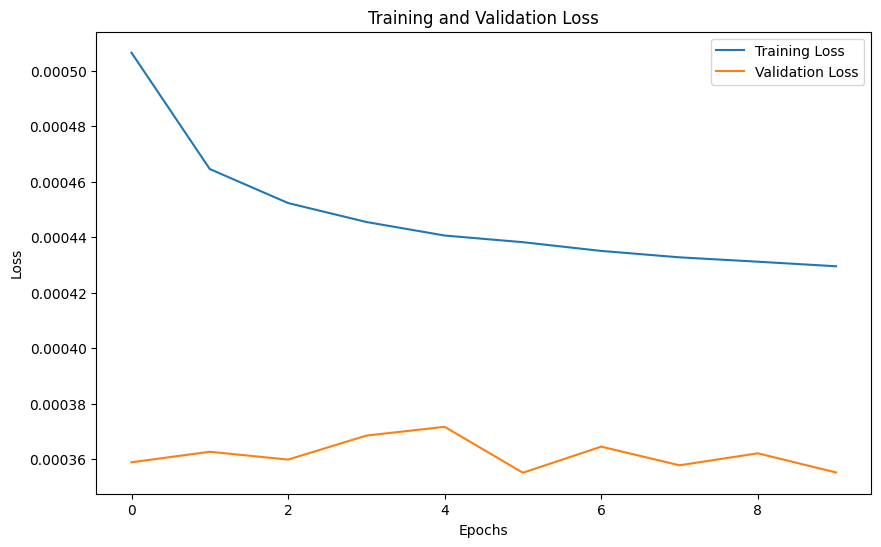

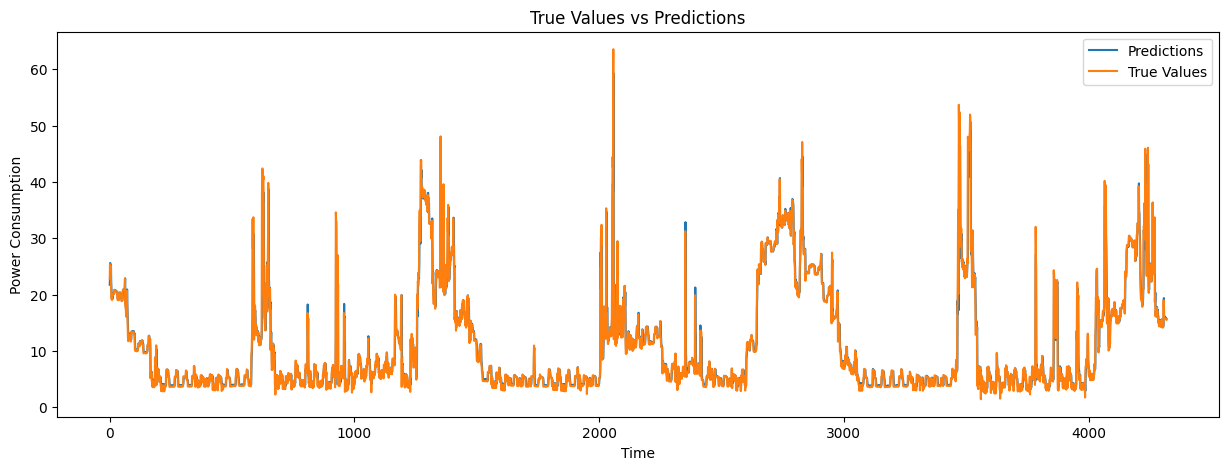

In [117]:
create_LSTM(X_train, y_train, X_test, y_test)

Comparison between Linear Regression, RNN and LSTM:
* MAE - 
    * LSTM has the lowest MAE, indicating that LSTM has the smallest average error in predictions.
* MSE & RMSE - 
    * LSTM has the lowest MSE and RMSE values, indicating that LSTM has the least amount of large error predictions.
* R-squared - 
    * LSTM has the highest R-squared value, indicating that it explains the variance of the dataset the best out of the 3 models.

Attention:

In [118]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.W = None
        self.b = None

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1], ), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        return tf.reduce_sum(x * a, axis=1), a

In [119]:
def create_attention_model(X_train, y_train, X_test, y_test):
    inputs = tf.keras.layers.Input(shape=(SEQ_LENGTH, 1))
    lstm_out = tf.keras.layers.LSTM(50, return_sequences=True)(inputs)
    attention_out, attention_weights = Attention()(lstm_out)
    output = tf.keras.layers.Dense(1)(attention_out)
    attn_model = tf.keras.models.Model(inputs=inputs, outputs=[output, attention_weights])


    print('Start training')
    attn_model.compile(optimizer='adam', loss='mean_squared_error')
    history = attn_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))
    print('End training')

    test_loss = attn_model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss:.4f}")

    y_pred, attn_weights = attn_model.predict(X_test)

    y_pred = scaler.inverse_transform(y_pred)
    y_test_attn = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_attn, y_pred)
    mae = mean_absolute_error(y_test_attn, y_pred)
    r2 = r2_score(y_test_attn, y_pred)
    rmse = np.sqrt(mse)

    print(f'Mean Absolute Error (Attention): {mae}')
    print(f'Mean Squared Error (Attention): {mse}')
    print(f'Root Mean Squared Error (Attention): {rmse}')
    print(f'R-squared (Attention): {r2}')

    plot_loss_over_training(history)
    plot_preds_and_true(y_pred, y_test_attn)

    for i in range(3):  # Plotting attention weights for 3 sequences
        plt.figure(figsize=(10, 4))
        sns.heatmap(attn_weights[i].T, cmap='viridis', cbar=True)
        plt.title(f'Attention Weights for Test Sequence {i+1}')
        plt.xlabel('Time Step')
        plt.ylabel('Attention Weight')
        plt.show()

Start training
Epoch 1/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 155s 9ms/step - loss: 8.6478e-04 - val_loss: 4.1015e-04
Epoch 2/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 148s 9ms/step - loss: 4.8376e-04 - val_loss: 3.6758e-04
Epoch 3/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 145s 9ms/step - loss: 4.6828e-04 - val_loss: 3.6493e-04
Epoch 4/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 145s 9ms/step - loss: 4.4752e-04 - val_loss: 3.7697e-04
Epoch 5/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 146s 9ms/step - loss: 4.4007e-04 - val_loss: 3.6752e-04
Epoch 6/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 147s 9ms/step - loss: 4.3516e-04 - val_loss: 3.7010e-04
Epoch 7/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 146s 9ms/step - loss: 4.3073e-04 - val_loss: 3.6237e-04
Epoch 8/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 146s 9ms/step - loss: 4.2475e-04 - val_loss: 3.6734e-04
Epoch 9/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 146s 9ms/step - loss: 4.2447e-04 - val_loss: 3.7700e-04
Epoch 10/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 146s 9ms/step - loss: 4.2432e-04 - val_l

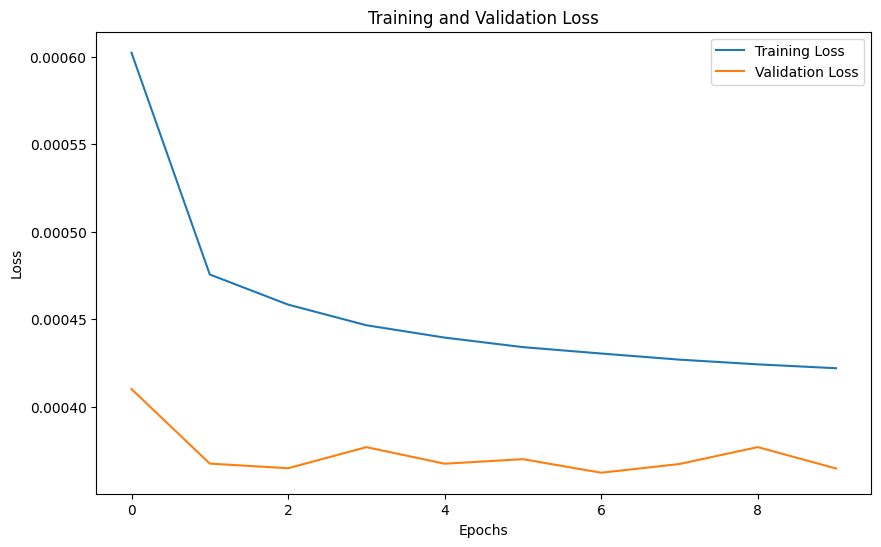

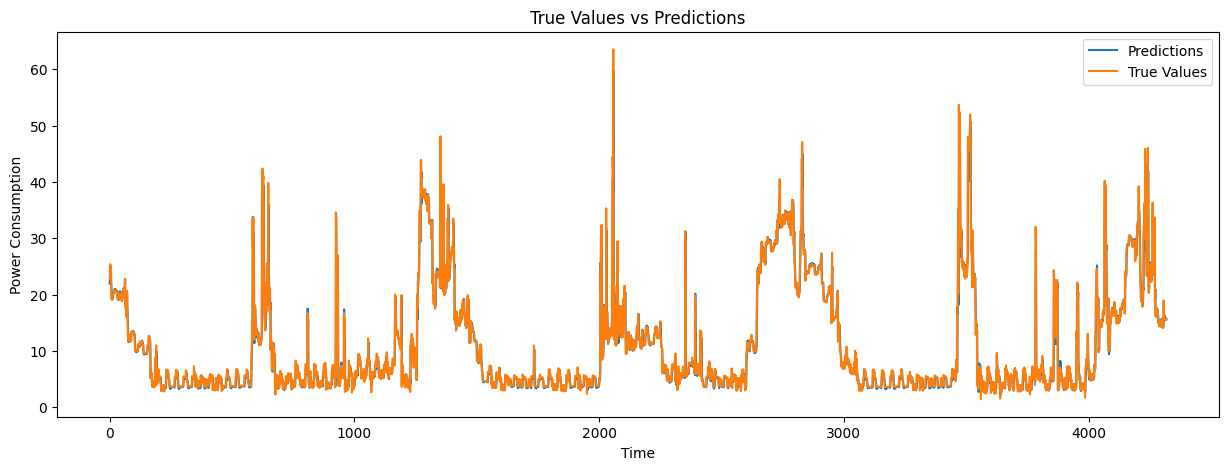

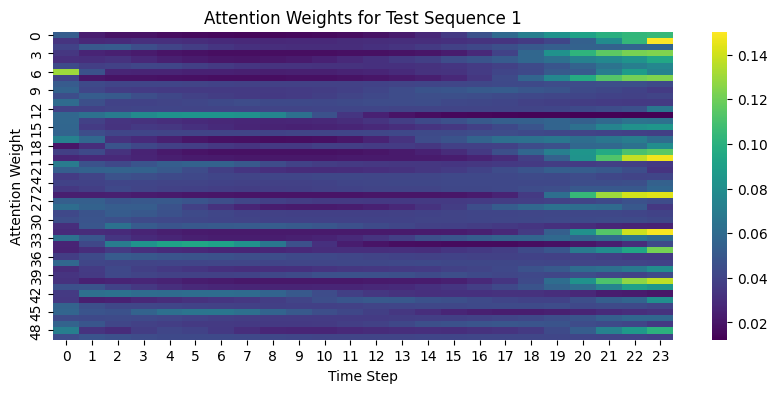

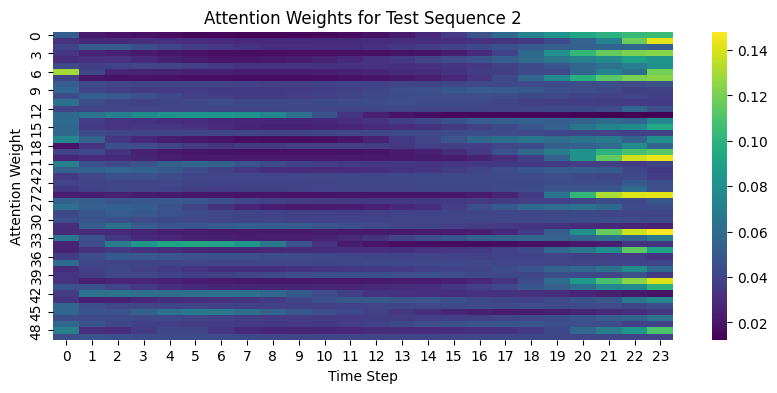

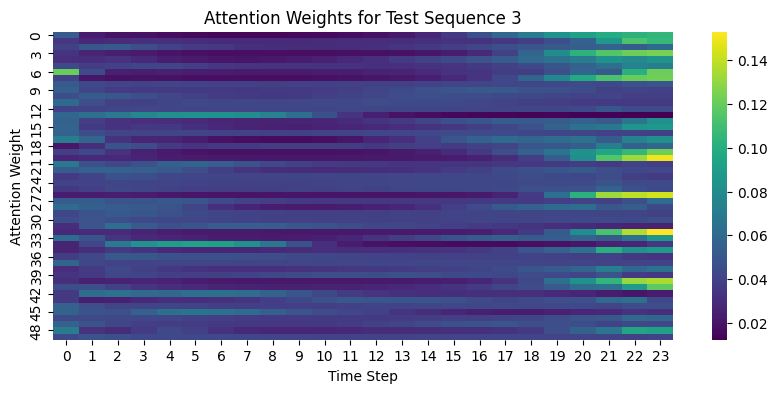

In [120]:
create_attention_model(X_train, y_train, X_test, y_test)

* Time Step 0:
    * The first time step shows some higher attention weights at different indices, suggesting initial data might be important.
* Middle Time Steps (10-15):
    * These time steps show varied but relatively higher attention weights compared to others, indicating a possible middle sequence importance.
* Last Time Steps (20-23):
    * The end of the sequence has increased attention weights in some indices, which could signify the model considers the recent past crucial for its predictions.

Comparison between Linear Regression, RNN, LSTM and Attention-LSTM:
* MAE - 
    * Attention-LSTM has higher MAE score than RNN and LSTM, indicating that Attention-LSTM has the second highest average error in predictions.
* MSE & RMSE - 
    * Attention-LSTM has the second lowest MSE and RMSE values after LSTM, indicating that Attention-LSTM has the second least amount of large error predictions.
* R-squared - 
    * Attention-LSTM has the second highest R-squared value, indicating that LSTM explains the variance of the dataset the best out of the 4 models.

Data augmentation:

In [121]:
scaler = MinMaxScaler()

scaled_df = create_features(power_df.copy())

scaled_df['power_consumption'] = scaler.fit_transform(scaled_df[['power_consumption']])

X, y = create_seq(scaled_df['power_consumption'].values)

X = X.reshape((X.shape[0], X.shape[1], 1))

X_train_aug, X_test_aug = data_split(X)
y_train_aug, y_test_aug = data_split(y)

data_split finish
data_split finish


In [122]:
np.random.seed(0)
num_aug = int(0.1 * len(X_train_aug))

indices_aug = np.random.choice(len(X_train), num_aug, replace=False)
noise = np.random.normal(0, 0.05, (num_aug, SEQ_LENGTH, 1))
X_train_aug[indices_aug] += noise

Start training
Epoch 1/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 5.6642e-04 - val_loss: 3.7232e-04
Epoch 2/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 5.1126e-04 - val_loss: 3.6863e-04
Epoch 3/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 5.0898e-04 - val_loss: 3.6148e-04
Epoch 4/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 4.9812e-04 - val_loss: 3.6636e-04
Epoch 5/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 4.9161e-04 - val_loss: 3.6473e-04
Epoch 6/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 4.9811e-04 - val_loss: 3.6396e-04
Epoch 7/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 4.9891e-04 - val_loss: 3.7104e-04
Epoch 8/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 5.1270e-04 - val_loss: 3.6557e-04
Epoch 9/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 4.9425e-04 - val_loss: 3.5948e-04
Epoch 10/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 4.9478e-04 - val_loss: 3.619

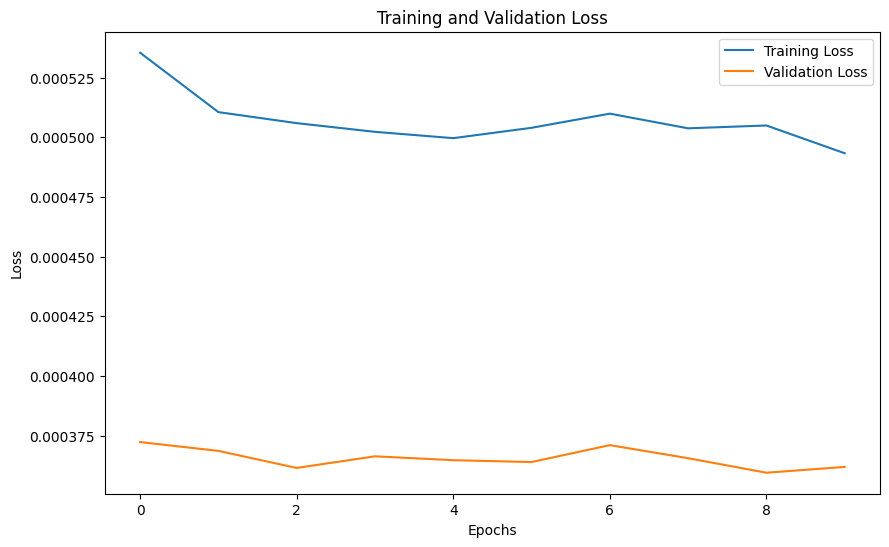

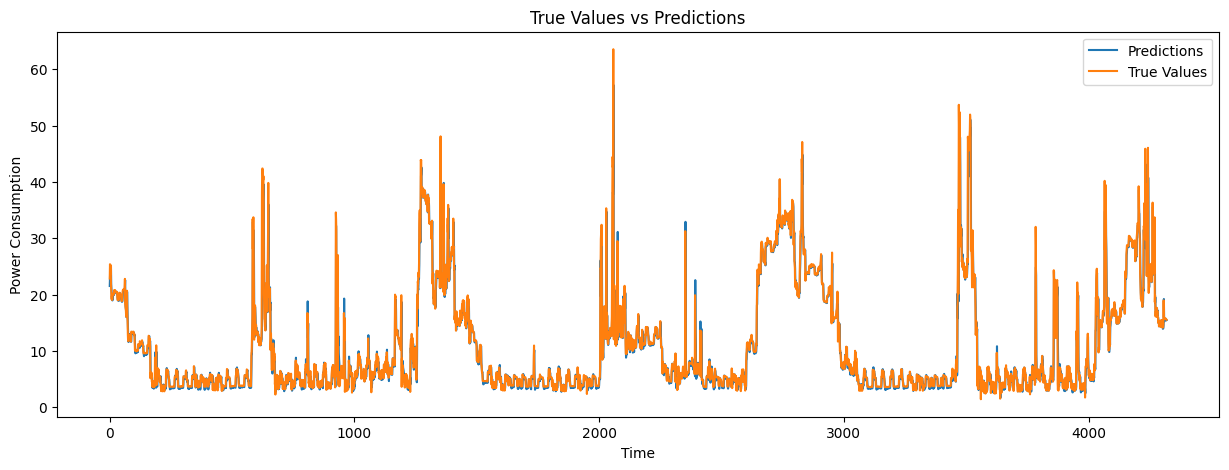

In [123]:
create_rnn(X_train_aug, y_train_aug, X_test_aug, y_test_aug)

Comparison between RNN and RNN with data augmentation:
* MAE - 
    * After the data augmentation, RNN has a higher MAE score, indicating that the data augmentation may cause the model to have results that are on average further from the real values comparing to RNN without the data augmentation.
* MSE & RMSE - 
    * After the data augmentation, RNN has a lower MSE & RMSE scores, indicating that after the data augmentation, RNN has less large errors.
* R-squared - 
    * After the data augmentation, RNN has a higher R-squared score, indicating that after the data augmentation, RNN can explain the variance of the data better.

Start training
Epoch 1/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 110s 7ms/step - loss: 6.8051e-04 - val_loss: 3.6243e-04
Epoch 2/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 104s 6ms/step - loss: 5.0969e-04 - val_loss: 3.6985e-04
Epoch 3/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 102s 6ms/step - loss: 4.9186e-04 - val_loss: 3.5954e-04
Epoch 4/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 100s 6ms/step - loss: 4.8205e-04 - val_loss: 3.8581e-04
Epoch 5/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 101s 6ms/step - loss: 4.7956e-04 - val_loss: 3.7053e-04
Epoch 6/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 100s 6ms/step - loss: 4.7208e-04 - val_loss: 3.6134e-04
Epoch 7/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 101s 6ms/step - loss: 4.6667e-04 - val_loss: 3.6443e-04
Epoch 8/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 114s 7ms/step - loss: 4.6244e-04 - val_loss: 3.6876e-04
Epoch 9/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 106s 7ms/step - loss: 4.6513e-04 - val_loss: 3.6032e-04
Epoch 10/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 107s 7ms/step - loss: 4.6372e-04 - val_l

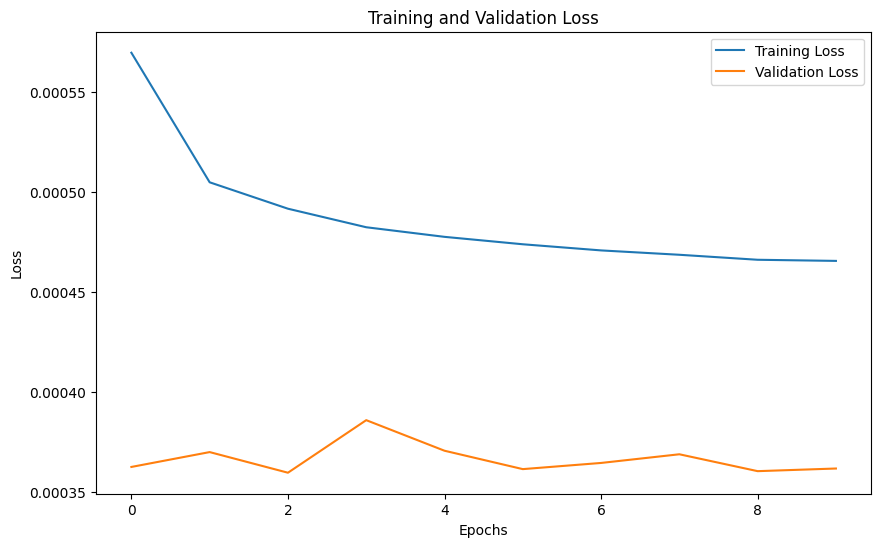

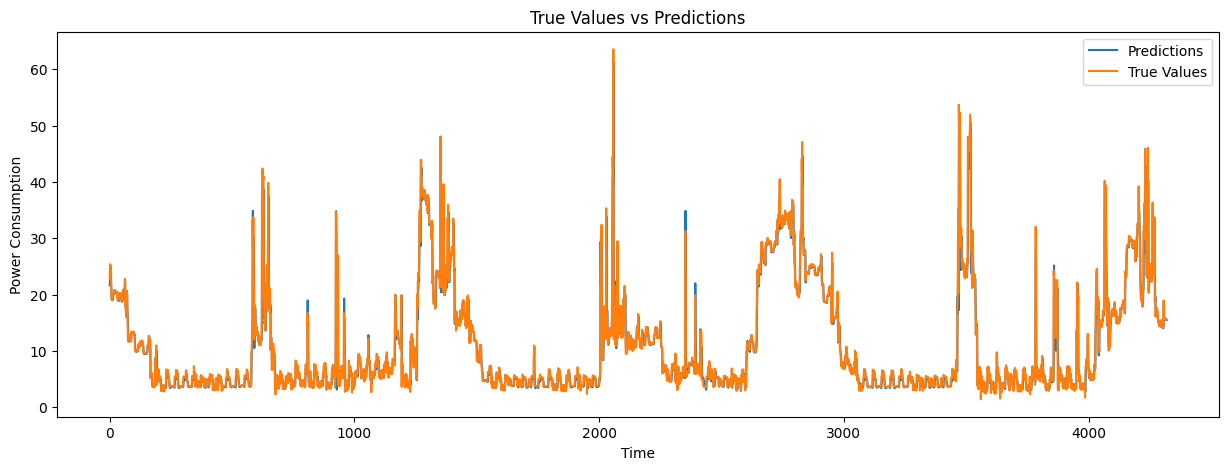

In [124]:
create_LSTM(X_train_aug, y_train_aug, X_test_aug, y_test_aug)

Comparison between LSTM and LSTM with data augmentation:
* MAE - 
    * After the data augmentation, LSTM has a higher MAE score, indicating that the data augmentation may cause the model to have results that are on average further from the real values comparing to LSTM without the data augmentation.
* MSE & RMSE - 
    * After the data augmentation, LSTM has a higher MSE & RMSE scores, indicating that after the data augmentation, LSTM has more large errors.
* R-squared - 
    * After the data augmentation, LSTM has a lower R-squared score, indicating that after the data augmentation, LSTM can explain the variance of the data worse compared to LSTM without data augmentation.

Start training
Epoch 1/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 128s 8ms/step - loss: 8.9531e-04 - val_loss: 3.8154e-04
Epoch 2/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 125s 8ms/step - loss: 5.4233e-04 - val_loss: 3.8263e-04
Epoch 3/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 124s 8ms/step - loss: 4.9667e-04 - val_loss: 3.7670e-04
Epoch 4/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 125s 8ms/step - loss: 4.9381e-04 - val_loss: 3.6694e-04
Epoch 5/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 125s 8ms/step - loss: 4.8426e-04 - val_loss: 3.7510e-04
Epoch 6/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 122s 8ms/step - loss: 4.7674e-04 - val_loss: 3.6771e-04
Epoch 7/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 121s 8ms/step - loss: 4.7084e-04 - val_loss: 3.6475e-04
Epoch 8/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 128s 8ms/step - loss: 4.6743e-04 - val_loss: 3.6134e-04
Epoch 9/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 128s 8ms/step - loss: 4.5732e-04 - val_loss: 3.8796e-04
Epoch 10/10
16179/16179 ━━━━━━━━━━━━━━━━━━━━ 129s 8ms/step - loss: 4.5631e-04 - val_l

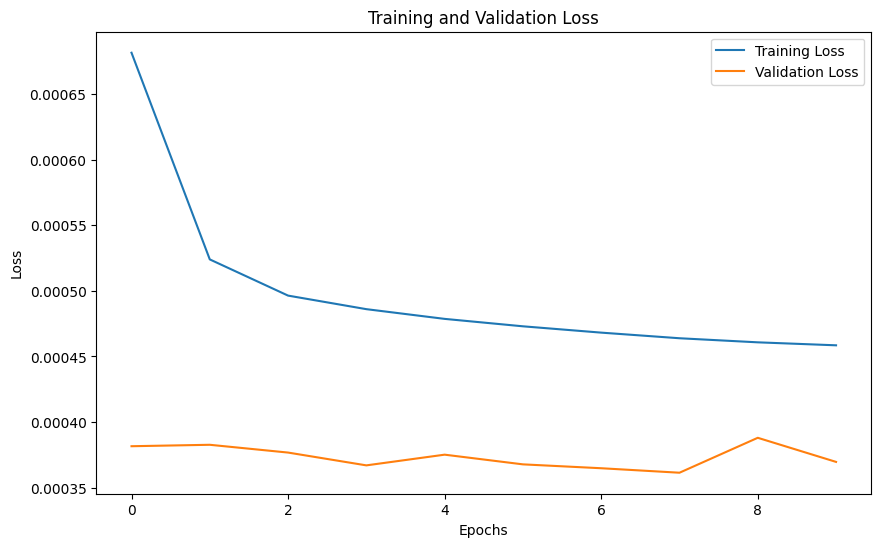

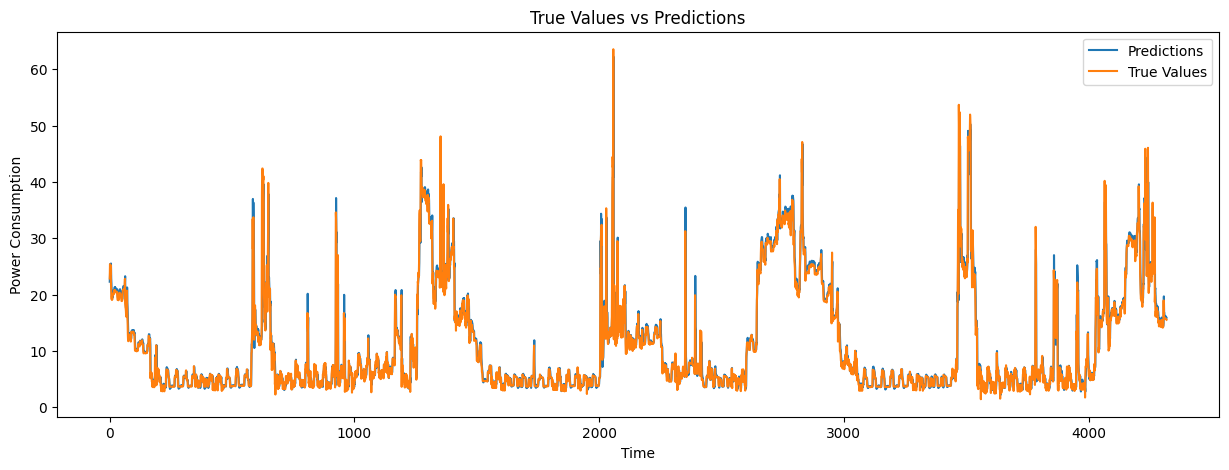

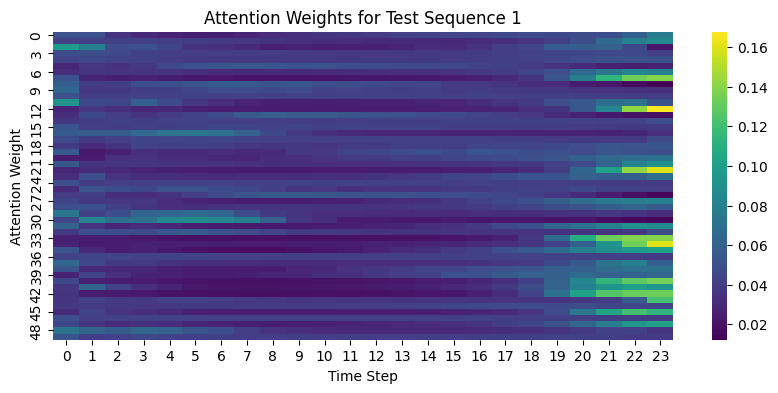

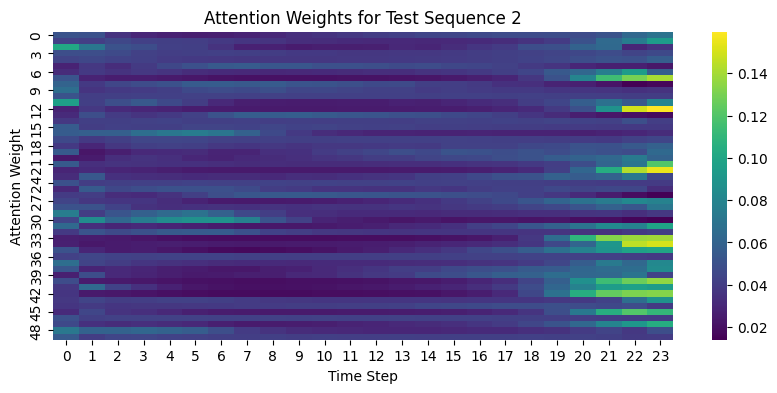

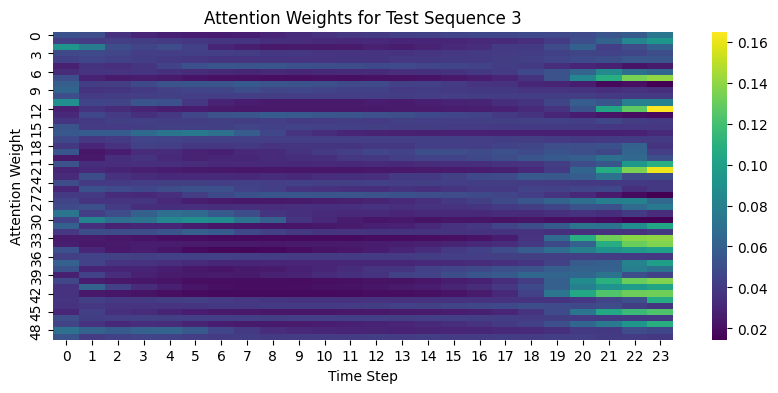

In [125]:
create_attention_model(X_train_aug, y_train_aug, X_test_aug, y_test_aug)

* Time Step 0:
    * The first time step shows some higher attention weights at different indices, suggesting initial data might be important.
* Middle Time Steps (6-10):
    * These time steps show varied but relatively higher attention weights compared to others, indicating a possible middle sequence importance.
* Last Time Steps (20-23):
    * The end of the sequence has increased attention weights in some indices, which could signify the model considers the recent past crucial for its predictions.

Comparison between Attention-LSTM and Attention-LSTM with data augmentation:
* MAE - 
    * After the data augmentation, Attention-LSTM has a lower MAE score, indicating that the data augmentation may cause the model to have results that are on average closer to the real values comparing to Attention-LSTM without the data augmentation.
* MSE & RMSE - 
    * After the data augmentation, Attention-LSTM has a lower MSE & RMSE scores, indicating that after the data augmentation, Attention-LSTM has less large errors.
* R-squared - 
    * After the data augmentation, Attention-LSTM has a higher R-squared score, indicating that after the data augmentation, Attention-LSTM can explain the variance of the data better compared to Attention-LSTM without data augmentation.

Data reduction:

In [126]:
scaler = MinMaxScaler()

scaled_df = create_features(power_df.copy())

scaled_df['power_consumption'] = scaler.fit_transform(scaled_df[['power_consumption']])

X, y = create_seq(scaled_df['power_consumption'].values)

X = X.reshape((X.shape[0], X.shape[1], 1))

X_train_red, X_test_red = data_split(X)
y_train_red, y_test_red = data_split(y)

data_split finish
data_split finish


In [127]:
np.random.seed(0)
num_samples_train = len(X_train_red)
num_removals_train = int(0.1 * num_samples_train)
indices_to_remove_train = np.random.choice(num_samples_train, num_removals_train, replace=False)

X_train_red = np.delete(X_train_red, indices_to_remove_train, axis=0)
y_train_red = np.delete(y_train_red, indices_to_remove_train, axis=0)

Start training
Epoch 1/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 5.3638e-04 - val_loss: 3.6784e-04
Epoch 2/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 4.7095e-04 - val_loss: 3.6824e-04
Epoch 3/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 4.6449e-04 - val_loss: 3.6269e-04
Epoch 4/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 4.6046e-04 - val_loss: 3.7044e-04
Epoch 5/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 4.6001e-04 - val_loss: 3.8499e-04
Epoch 6/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 4.5227e-04 - val_loss: 3.6524e-04
Epoch 7/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 4.5306e-04 - val_loss: 3.9259e-04
Epoch 8/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 4.5439e-04 - val_loss: 3.6176e-04
Epoch 9/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 4.4676e-04 - val_loss: 3.7137e-04
Epoch 10/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 4.4827e-04 - val_loss: 3.556

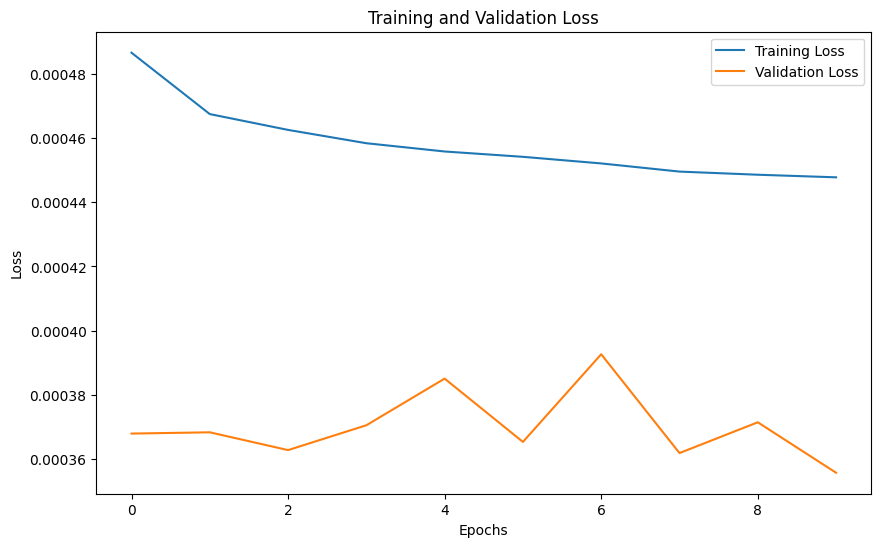

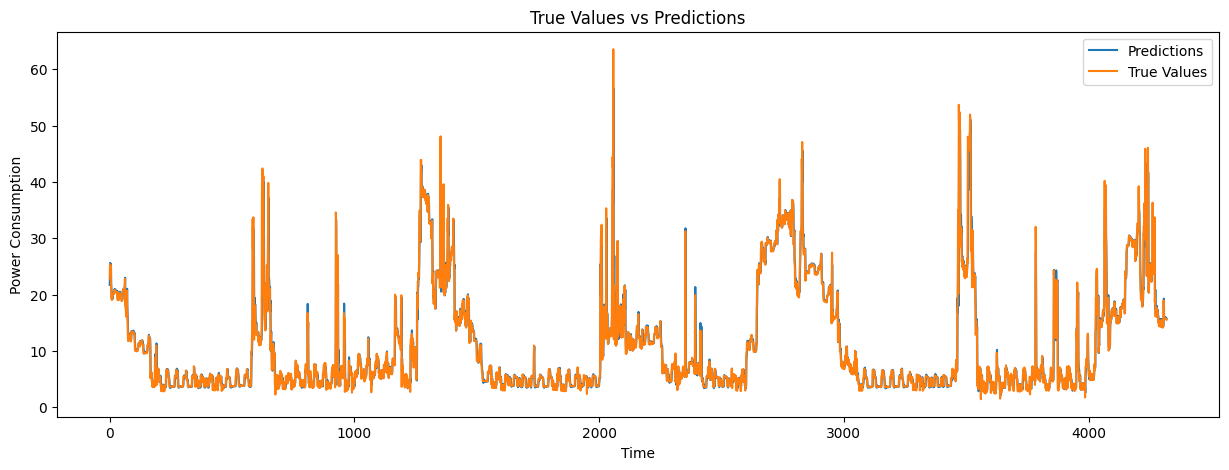

In [128]:
create_rnn(X_train_red, y_train_red, X_test_red, y_test_red)

Comparison between RNN and RNN with data reduction:
* MAE - 
    * After the data reduction, RNN has a higher MAE score, indicating that the data reduction may cause the model to have results that are on average further from the real values comparing to RNN without the data reduction.
* MSE & RMSE - 
    * After the data reduction, RNN has a lower MSE & RMSE scores, indicating that after the data reduction, RNN has less large errors.
* R-squared - 
    * After the data reduction, RNN has a higher R-squared score, indicating that after the data reduction, RNN can explain the variance of the data better compared to RNN without data reduction.

Start training
Epoch 1/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 97s 7ms/step - loss: 7.2251e-04 - val_loss: 3.7200e-04
Epoch 2/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 95s 7ms/step - loss: 4.7764e-04 - val_loss: 3.8557e-04
Epoch 3/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - loss: 4.6534e-04 - val_loss: 3.8921e-04
Epoch 4/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - loss: 4.5321e-04 - val_loss: 3.6820e-04
Epoch 5/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 95s 6ms/step - loss: 4.4564e-04 - val_loss: 3.5988e-04
Epoch 6/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - loss: 4.3759e-04 - val_loss: 3.5881e-04
Epoch 7/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - loss: 4.3945e-04 - val_loss: 3.6502e-04
Epoch 8/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 95s 7ms/step - loss: 4.2961e-04 - val_loss: 3.6867e-04
Epoch 9/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 95s 7ms/step - loss: 4.2663e-04 - val_loss: 3.6073e-04
Epoch 10/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - loss: 4.2678e-04 - val_loss: 3.600

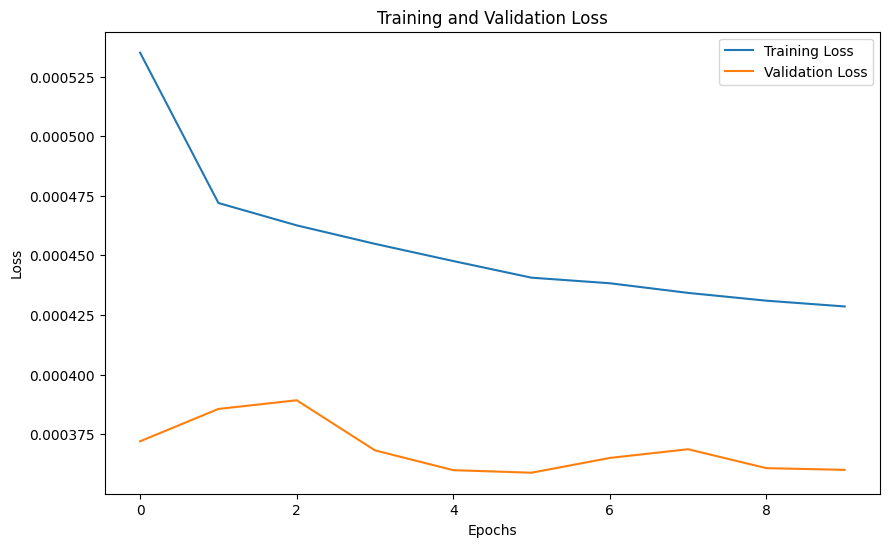

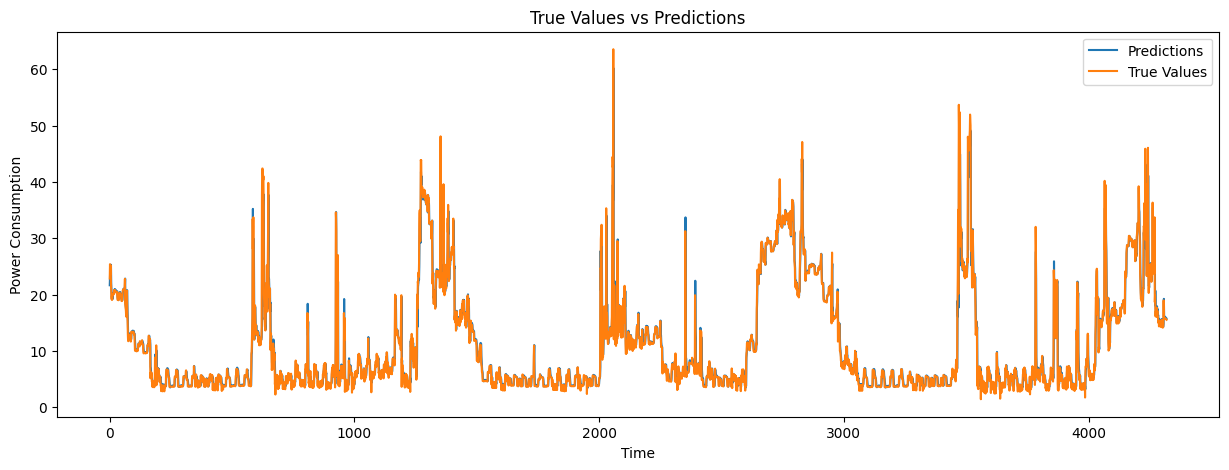

In [129]:
create_LSTM(X_train_red, y_train_red, X_test_red, y_test_red)

Comparison between LSTM and LSTM with data reduction:
* MAE - 
    * After the data reduction, LSTM has a higher MAE score, indicating that the data reduction may cause the model to have results that are on average further to the real values comparing to LSTM without the data reduction.
* MSE & RMSE - 
    * After the data reduction, LSTM has a higher MSE & RMSE scores, indicating that after the data reduction, LSTM has more large errors.
* R-squared - 
    * After the data reduction, LSTM has a lower R-squared score, indicating that after the data reduction, LSTM can explain the variance of the data worse compared to LSTM without data reduction.

Start training
Epoch 1/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 115s 8ms/step - loss: 8.4361e-04 - val_loss: 4.0180e-04
Epoch 2/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 113s 8ms/step - loss: 4.8361e-04 - val_loss: 3.7014e-04
Epoch 3/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 113s 8ms/step - loss: 4.5976e-04 - val_loss: 3.7071e-04
Epoch 4/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 114s 8ms/step - loss: 4.5317e-04 - val_loss: 3.8204e-04
Epoch 5/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 112s 8ms/step - loss: 4.4281e-04 - val_loss: 3.7320e-04
Epoch 6/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 113s 8ms/step - loss: 4.4123e-04 - val_loss: 3.6835e-04
Epoch 7/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 115s 8ms/step - loss: 4.3301e-04 - val_loss: 3.7498e-04
Epoch 8/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 114s 8ms/step - loss: 4.3358e-04 - val_loss: 3.6540e-04
Epoch 9/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 114s 8ms/step - loss: 4.2845e-04 - val_loss: 3.6366e-04
Epoch 10/10
14562/14562 ━━━━━━━━━━━━━━━━━━━━ 115s 8ms/step - loss: 4.2944e-04 - val_l

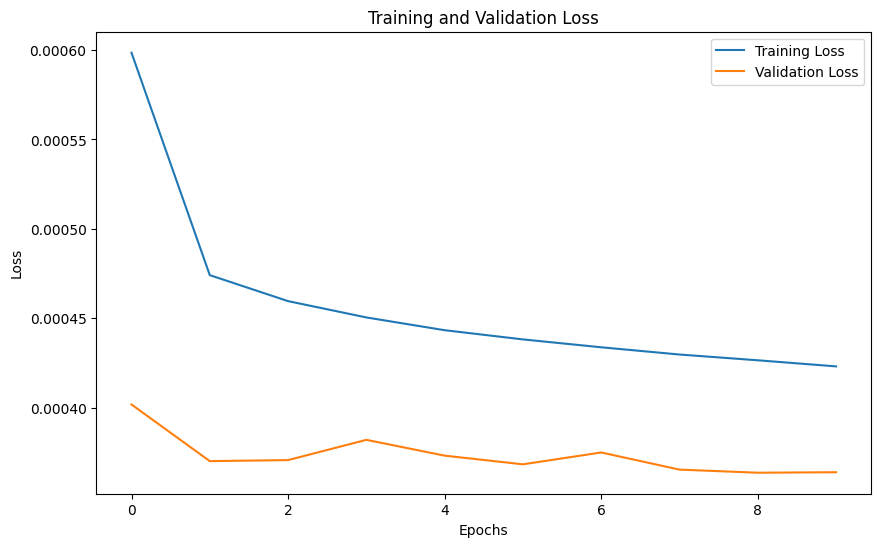

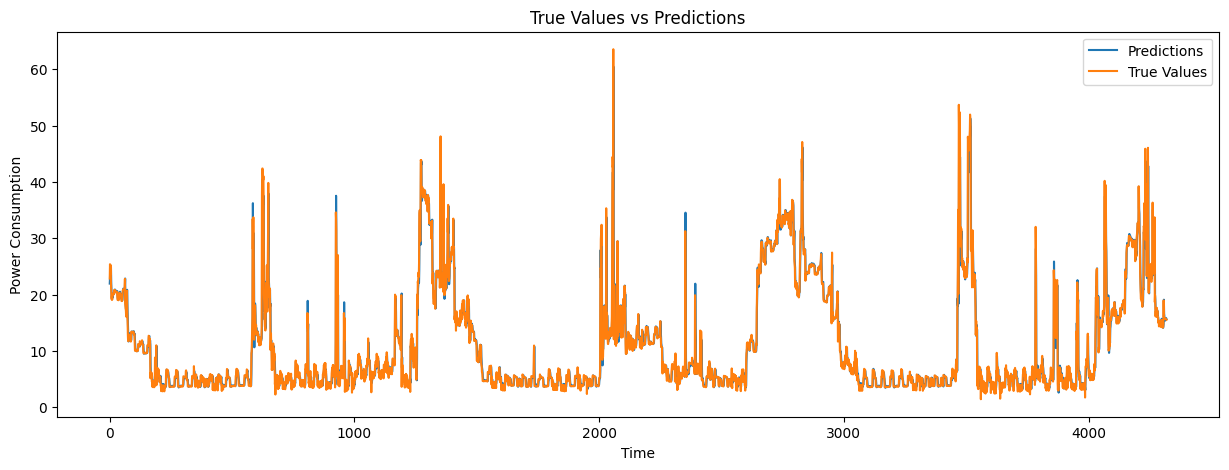

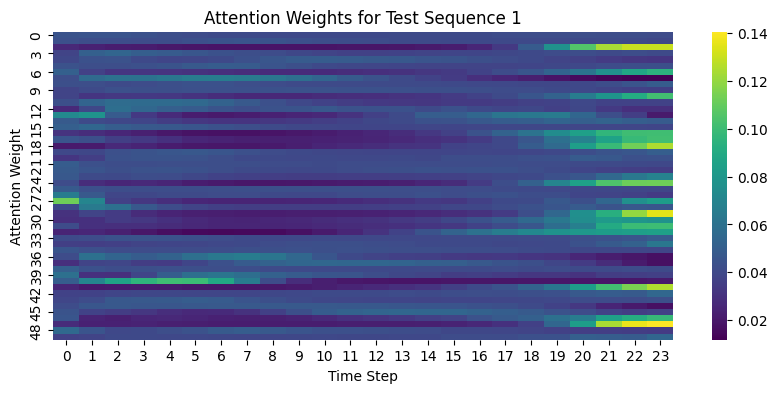

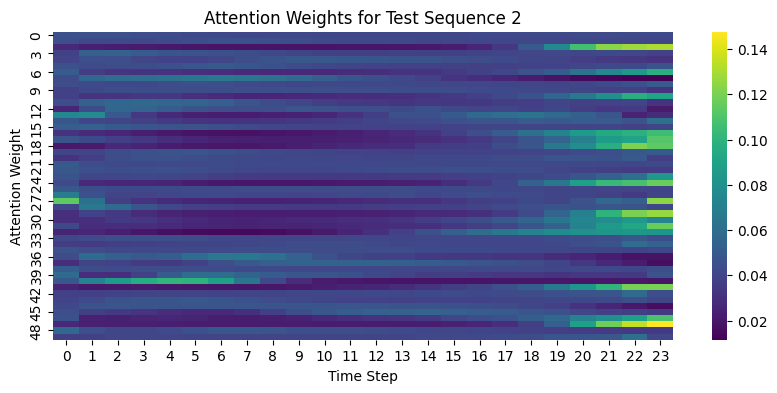

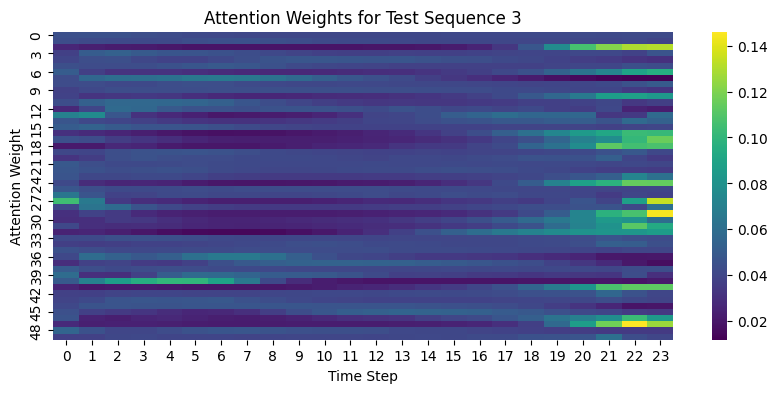

In [130]:
create_attention_model(X_train_red, y_train_red, X_test_red, y_test_red)

* Time Step 0:
    * The first time step shows some higher attention weights at different indices, suggesting initial data might be important.
* Middle Time Steps (5-10):
    * These time steps show varied but relatively higher attention weights compared to others, indicating a possible middle sequence importance.
* Last Time Steps (20-23):
    * The end of the sequence has increased attention weights in some indices, which could signify the model considers the recent past crucial for its predictions.

Comparison between Attention-LSTM and Attention-LSTM with data reduction:
* MAE - 
    * After the data reduction, Attention-LSTM has a lower MAE score, indicating that the data reduction may cause the model to have results that are on average closer to the real values comparing to Attention-LSTM without the data reduction.
* MSE & RMSE - 
    * After the data reduction, Attention-LSTM has a lower MSE & RMSE scores, indicating that after the data reduction, Attention-LSTM has less large errors.
* R-squared - 
    * After the data reduction, Attention-LSTM has a higher R-squared score, indicating that after the data reduction, Attention-LSTM can explain the variance of the data better compared to Attention-LSTM without data reduction.

Data resolution:

In [131]:
new_df = power_df.resample('2T').mean()

scaler = MinMaxScaler()

scaled_df = create_features(new_df.copy())

scaled_df['power_consumption'] = scaler.fit_transform(scaled_df[['power_consumption']])

X, y = create_seq(scaled_df['power_consumption'].values)

X = X.reshape((X.shape[0], X.shape[1], 1))

X_train_2m, X_test_2m = data_split(X)
y_train_2m, y_test_2m = data_split(y)

data_split finish
data_split finish


Start training
Epoch 1/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 7.6984e-04 - val_loss: 5.5698e-04
Epoch 2/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 6.5474e-04 - val_loss: 5.5918e-04
Epoch 3/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 6.4884e-04 - val_loss: 5.5565e-04
Epoch 4/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 6.3595e-04 - val_loss: 5.6236e-04
Epoch 5/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 6.4017e-04 - val_loss: 5.9355e-04
Epoch 6/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 6.3440e-04 - val_loss: 5.5170e-04
Epoch 7/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 6.3344e-04 - val_loss: 5.5591e-04
Epoch 8/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 6.2951e-04 - val_loss: 5.6409e-04
Epoch 9/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 6.3031e-04 - val_loss: 5.6274e-04
Epoch 10/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 6.3551e-04 - val_loss: 5.6509e-04
End training
1

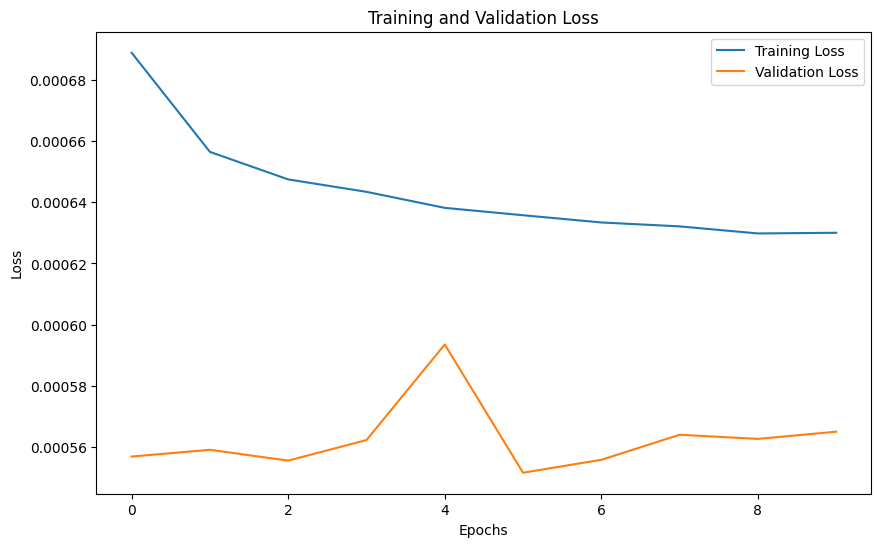

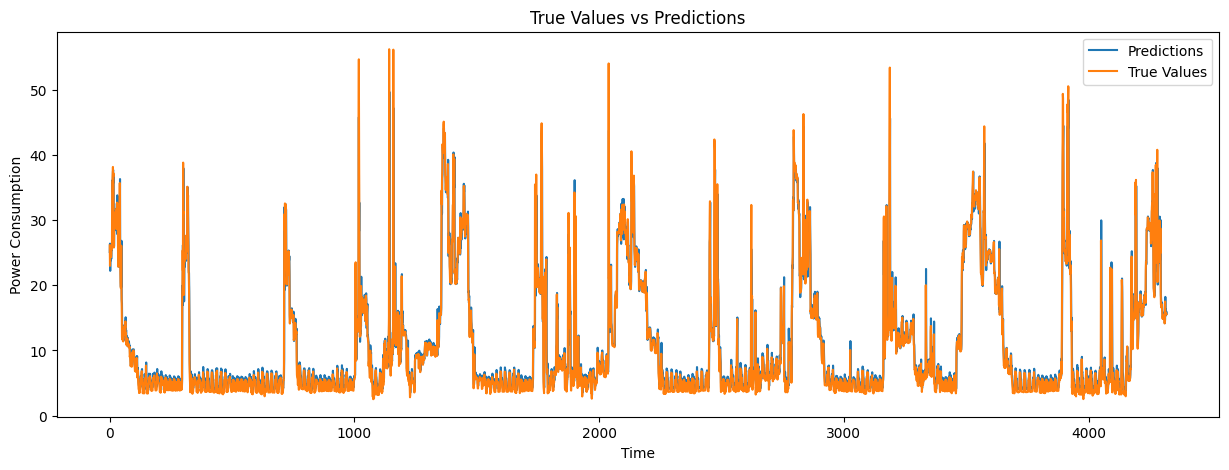

In [132]:
create_rnn(X_train_2m, y_train_2m, X_test_2m, y_test_2m)

Comparison between RNN and RNN with data resolution:
* MAE - 
    * After the data resolution, RNN has a signficantly higher MAE score, indicating that the data resolution may cause the model to have results that are on average further from the real values comparing to RNN without the data resolution.
* MSE & RMSE - 
    * After the data resolution, RNN has a signficantly higher MSE & RMSE scores, indicating that after the data resolution, RNN has more large errors.
* R-squared - 
    * After the data resolution, RNN has a lower R-squared score, indicating that after the data resolution, RNN can explain the variance of the data worse compared to RNN without data resolution.

Overall, RNN performs better without data resolution.
The performance reduction can be associated to the reduction of the dataset size which is caused by the data resolution.

Start training
Epoch 1/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - loss: 0.0010 - val_loss: 5.6974e-04
Epoch 2/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - loss: 6.8234e-04 - val_loss: 5.5287e-04
Epoch 3/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - loss: 6.5707e-04 - val_loss: 5.6331e-04
Epoch 4/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - loss: 6.5220e-04 - val_loss: 5.5475e-04
Epoch 5/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - loss: 6.3579e-04 - val_loss: 5.5148e-04
Epoch 6/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 6.3491e-04 - val_loss: 5.6117e-04
Epoch 7/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - loss: 6.2893e-04 - val_loss: 5.4893e-04
Epoch 8/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - loss: 6.2816e-04 - val_loss: 5.4286e-04
Epoch 9/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 6.2697e-04 - val_loss: 5.4399e-04
Epoch 10/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 6.3057e-04 - val_loss: 5.4040e-04
End training
135/1

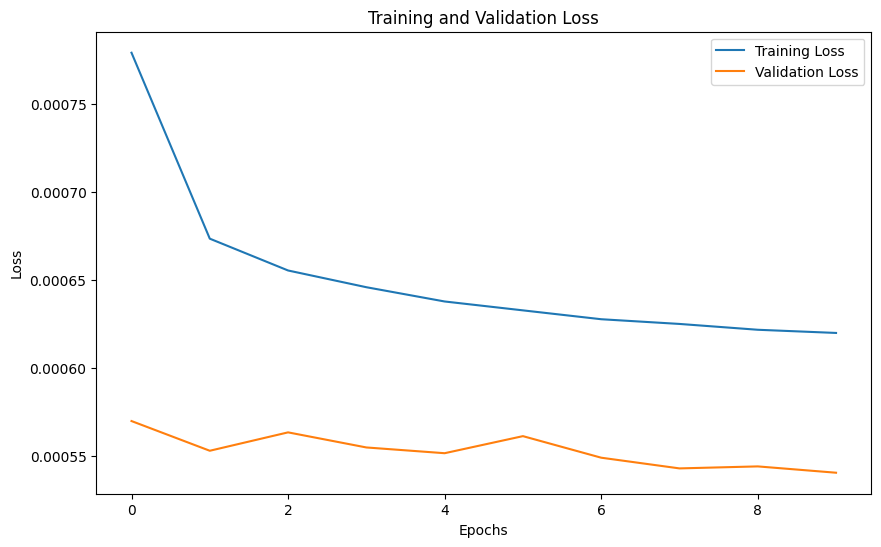

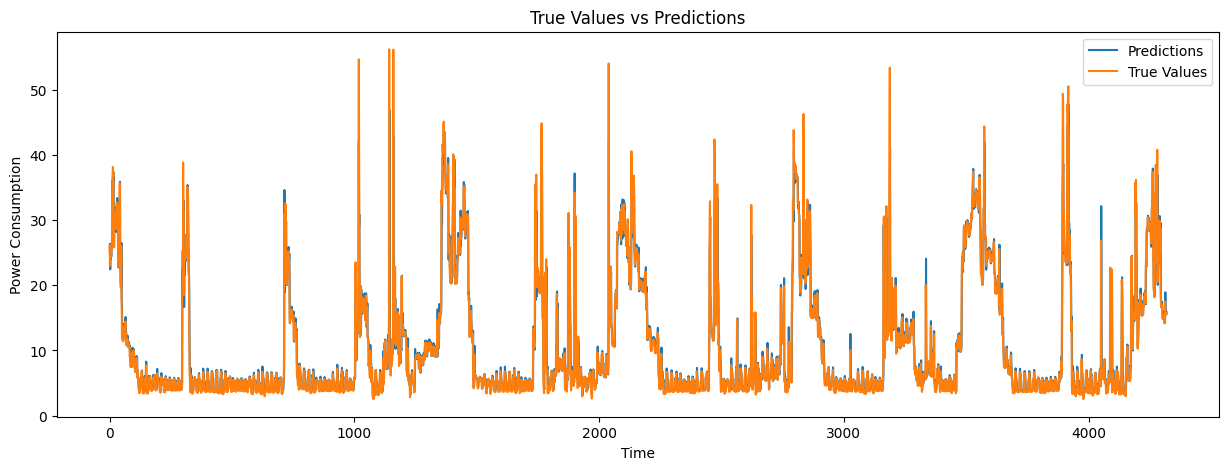

In [133]:
create_LSTM(X_train_2m, y_train_2m, X_test_2m, y_test_2m)

Comparison between LSTM and LSTM with data resolution:
* MAE - 
    * After the data resolution, LSTM has a signficantly higher MAE score, indicating that the data resolution may cause the model to have results that are on average further from the real values comparing to RNN without the data resolution.
* MSE & RMSE - 
    * After the data resolution, LSTM has a signficantly higher MSE & RMSE scores, indicating that after the data resolution, LSTM has more large errors.
* R-squared - 
    * After the data resolution, LSTM has a lower R-squared score, indicating that after the data resolution, LSTM can explain the variance of the data worse compared to RNN without data resolution.

Overall, LSTM performs better without data resolution.
The performance reduction can be associated to the reduction of the dataset size which is caused by the data resolution.

Start training
Epoch 1/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - loss: 0.0013 - val_loss: 5.9531e-04
Epoch 2/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 75s 9ms/step - loss: 7.0165e-04 - val_loss: 5.7717e-04
Epoch 3/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 75s 9ms/step - loss: 6.7816e-04 - val_loss: 5.6615e-04
Epoch 4/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 75s 9ms/step - loss: 6.6609e-04 - val_loss: 5.5477e-04
Epoch 5/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 74s 9ms/step - loss: 6.6517e-04 - val_loss: 5.7403e-04
Epoch 6/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 74s 9ms/step - loss: 6.4557e-04 - val_loss: 5.6810e-04
Epoch 7/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 75s 9ms/step - loss: 6.3843e-04 - val_loss: 5.4301e-04
Epoch 8/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 75s 9ms/step - loss: 6.3188e-04 - val_loss: 5.5308e-04
Epoch 9/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 74s 9ms/step - loss: 6.2451e-04 - val_loss: 5.6701e-04
Epoch 10/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 74s 9ms/step - loss: 6.2567e-04 - val_loss: 5.5628e-04
End training
135/1

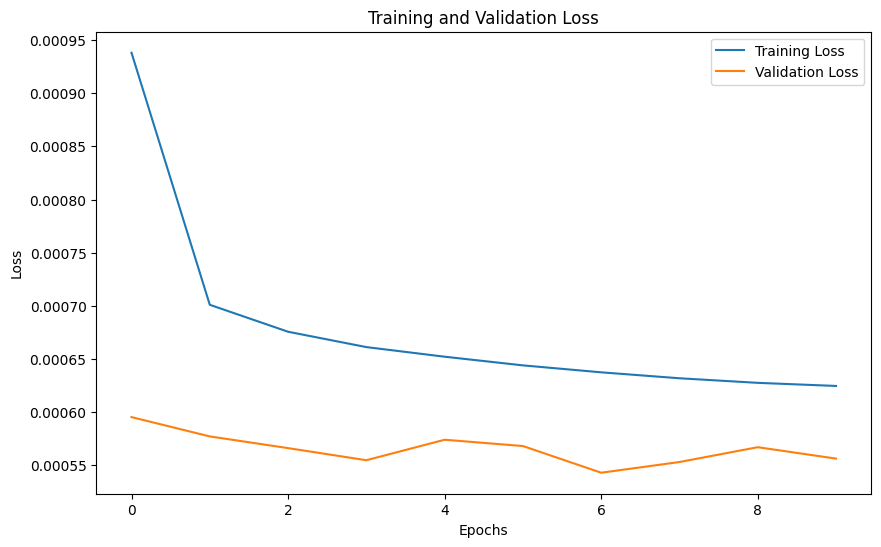

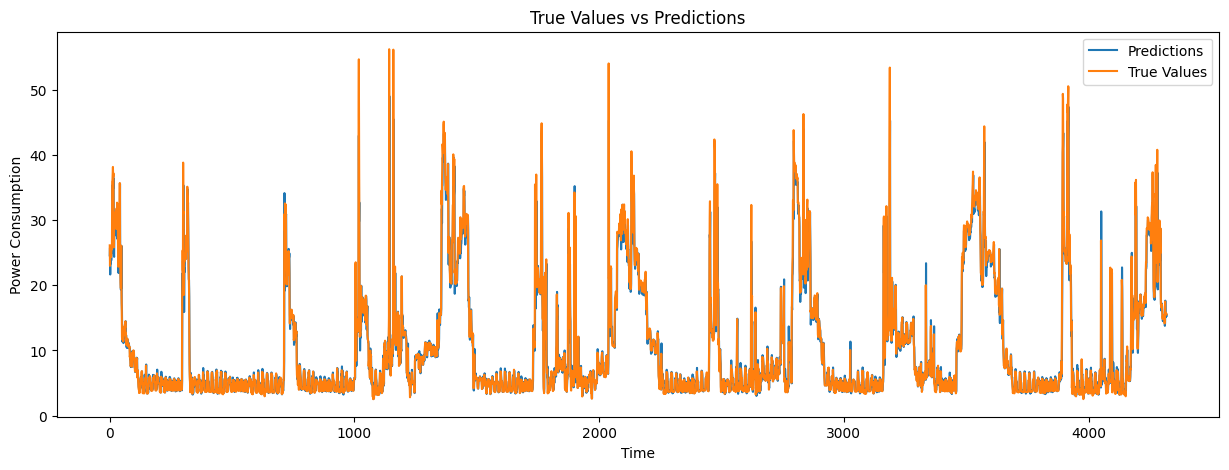

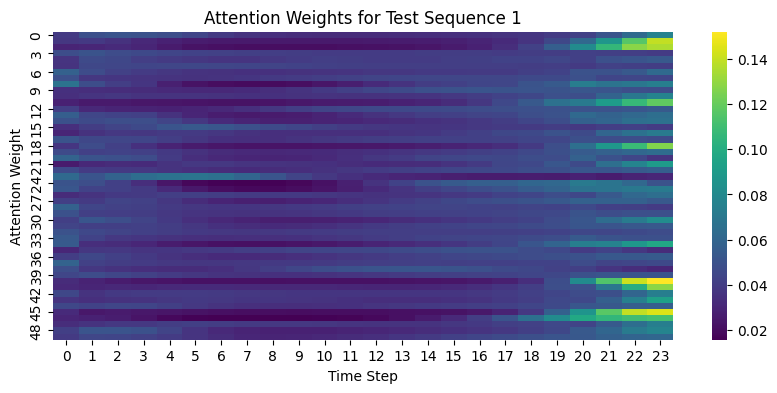

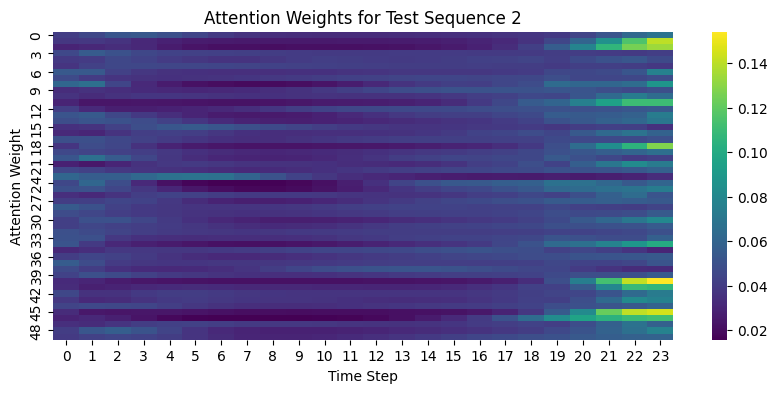

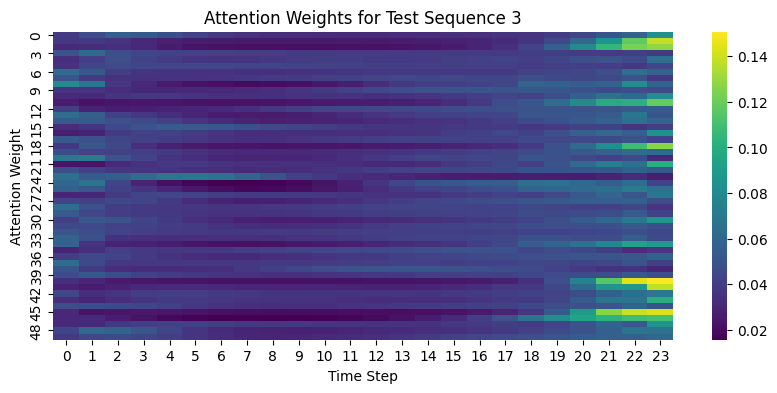

In [134]:
create_attention_model(X_train_2m, y_train_2m, X_test_2m, y_test_2m)

* Time Steps 0-10:
    * The initial time steps show some variations in attention weights, but not significantly high values compared to later steps.
* Middle Time Steps (11-15):
    * These time steps show a mix of lower and moderate attention weights, with some indices having slightly higher values.
* Last Time Steps (20-23):
    * The end of the sequence shows a noticeable increase in attention weights, particularly around indices 46-48. This indicates that the model is placing more emphasis on the recent past.

Comparison between Attention-LSTM and Attention-LSTM with data resolution:
* MAE - 
    * After the data resolution, Attention-LSTM has a signficantly higher MAE score, indicating that the data resolution may cause the model to have results that are on average further from the real values comparing to Attention-LSTM without the data resolution.
* MSE & RMSE - 
    * After the data resolution, Attention-LSTM has a signficantly higher MSE & RMSE scores, indicating that after the data resolution, Attention-LSTM has more large errors.
* R-squared - 
    * After the data resolution, Attention-LSTM has a lower R-squared score, indicating that after the data resolution, Attention-LSTM can explain the variance of the data worse compared to RNN without data resolution.

Overall, Attention-LSTM performs better without data resolution.
The performance reduction can be associated to the reduction of the dataset size which is caused by the data resolution.

Conclusions and insights:

* The RNN model performs best with the data reduction.
* The LSTM model performs best with the original dataset.
* The Attention-LSTM model performs best with the data reduction.
* All models perform the worst after the data resolution.
* There isn't a model that performs best over all datasets.
* Over all datasets, the Attention-LSTM model weights tend to have more importance for the later time steps rather than to the early time steps.